In [ ]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 12.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import torch
import torch.nn as nn
import seaborn as sns
import soundfile as sf
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring
from scipy.fftpack import dct
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_nonative_data():
    data_path_base = '/content/drive/MyDrive/dataset_full/'
    data_folder = 'nonative'
    phonics_directories = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                         'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

    data = []
    data_path = os.path.join(data_path_base, data_folder)

    for region in os.listdir(data_path):
        region_path = os.path.join(data_path, region)
        if os.path.isdir(region_path):
            for phonics in phonics_directories:
                phonics_path = os.path.join(region_path, phonics)
                if os.path.exists(phonics_path):
                    for file in os.listdir(phonics_path):
                        if file.endswith('.mp3'):
                            data.append({
                                'Phonics': phonics,
                                'Region': region,
                                'Path': os.path.join(phonics_path, file)
                            })

    return pd.DataFrame(data)

nonative_df = load_nonative_data()
print("Region distribution:\n", nonative_df['Region'].value_counts())

Region distribution:
 Region
jawa      156
papua     104
batam      78
bali       78
madura     78
Name: count, dtype: int64


# Spectrogram

In [ ]:
def speed_perturb(y, rate=1.1):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr, steps=1):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

In [ ]:
def plot_spectrogram(data, sample_rate, title, file_path=None):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    if file_path:
        plt.savefig(file_path)
        plt.close()
    else:
        plt.show()

# Setup save directory
save_path = '/content/drive/MyDrive/spectograms/experimentE/'
os.makedirs(save_path, exist_ok=True)

# Augment and plot
for index, row in nonative_df.iterrows():
    audio_path = row['Path']
    phonics_label = row['Phonics']

    data, sample_rate = librosa.load(audio_path, sr=None)

    # Original
    path_orig = os.path.join(save_path, f"{phonics_label}_original_{index}.png")
    plot_spectrogram(data, sample_rate, f"Original {phonics_label.upper()}", path_orig)

    # Speed Perturbation
    data_speed = speed_perturb(data, rate=1.1)
    path_speed = os.path.join(save_path, f"{phonics_label}_speed_{index}.png")
    plot_spectrogram(data_speed, sample_rate, f"Speed Perturbed {phonics_label.upper()}", path_speed)

    # Pitch Shift
    data_pitch = pitch_shift(data, sr=sample_rate, steps=1)
    path_pitch = os.path.join(save_path, f"{phonics_label}_pitch_{index}.png")
    plot_spectrogram(data_pitch, sample_rate, f"Pitch Shifted {phonics_label.upper()}", path_pitch)

print("Spectrograms saved successfully.")

Spectrograms saved successfully.


In [ ]:
def plot_spectrogram(data, sample_rate, title):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

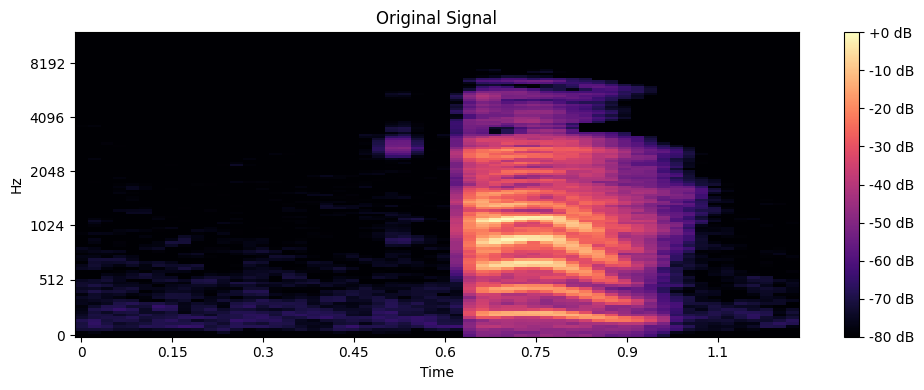

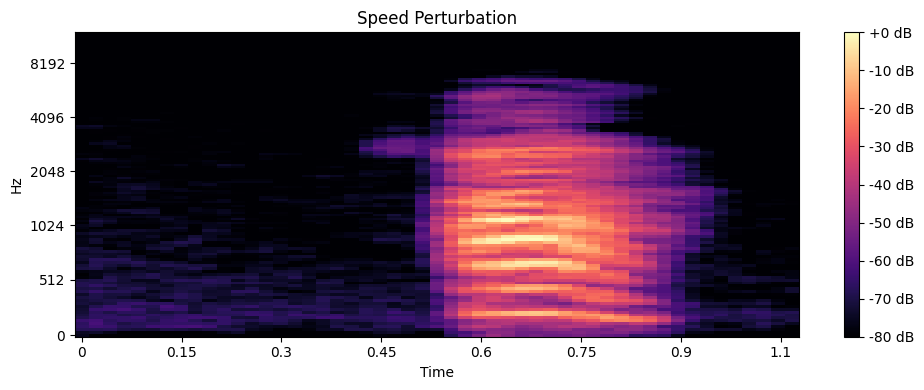

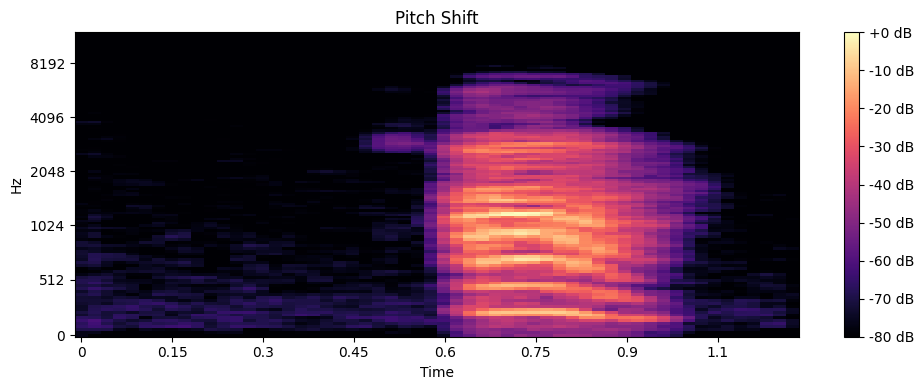

In [ ]:
sample_audio_path = nonative_df[nonative_df['Phonics'] == 'a']['Path'].iloc[0]
data_sample, sr_sample = librosa.load(sample_audio_path, sr=None)

speed_aug = speed_perturb(data_sample, rate=1.1)
pitch_aug = pitch_shift(data_sample, sr=sr_sample, steps=1)

plot_spectrogram(data_sample, sr_sample, 'Original Signal')
plot_spectrogram(speed_aug, sr_sample, 'Speed Perturbation')
plot_spectrogram(pitch_aug, sr_sample, 'Pitch Shift')

# Ekstraksi Fitur

In [ ]:
import scipy.signal
import numpy as np
import torch
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict

def medium_time_power(signal, M=2):
    padded = np.pad(signal, ((M, M), (0, 0)), mode='constant')
    return np.stack([
        np.mean(padded[i:i + 2 * M + 1], axis=0)
        for i in range(signal.shape[0])
    ])

def asym_lowpass(x, alpha=0.999, beta=0.5):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = np.where(x[i] >= y[i - 1],
                        alpha * y[i - 1] + (1 - alpha) * x[i],
                        beta * y[i - 1] + (1 - beta) * x[i])
    return y

def temporal_masking(x, lam=0.85, mu=0.2):
    peak = np.zeros_like(x)
    masked = np.zeros_like(x)
    peak[0] = x[0]
    masked[0] = x[0]
    for i in range(1, len(x)):
        peak[i] = np.maximum(lam * peak[i - 1], x[i])
        masked[i] = np.where(x[i] >= lam * peak[i - 1], x[i], mu * peak[i - 1])
    return masked

def weight_smoothing(x, ref, N=4):
    smoothed = np.zeros_like(x)
    for t in range(x.shape[0]):
        for f in range(x.shape[1]):
            l1 = max(f - N, 0)
            l2 = min(f + N + 1, x.shape[1])
            smoothed[t, f] = np.mean(x[t, l1:l2] / (ref[t, l1:l2] + 1e-6))
    return smoothed

def extract_pncc(data, sr, n_mels=40, n_fft=512, hop_length=160, win_length=400):
    try:
        data, _ = librosa.effects.trim(data, top_db=40)
        emphasized = scipy.signal.lfilter([1, -0.97], [1], data)

        stft = np.abs(librosa.stft(emphasized, n_fft=n_fft, hop_length=hop_length, win_length=win_length)) ** 2
        mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
        mel_spec = np.dot(mel_basis, stft).T

        mt_power = medium_time_power(mel_spec)
        low_env = asym_lowpass(mt_power)
        subtracted = mt_power - low_env
        rectified = np.maximum(0, subtracted)
        floor = asym_lowpass(rectified)
        masked = temporal_masking(rectified)
        switched = np.where(mt_power >= 2 * low_env, masked, floor)
        smoothed = weight_smoothing(switched, mt_power)
        tf_norm = mel_spec * smoothed

        mean_power = np.zeros(tf_norm.shape[0])
        mean_power[0] = 0.0001
        for i in range(1, tf_norm.shape[0]):
            mean_power[i] = 0.999 * mean_power[i - 1] + 0.001 * np.mean(tf_norm[i])
        norm = tf_norm / (mean_power[:, None] + 1e-6)

        nonlin = norm ** (1 / 15)
        return (nonlin - np.mean(nonlin)) / (np.std(nonlin) + 1e-6)
    except Exception as e:
        print(f"Error in PNCC extraction: {e}")
        return None

def extract_tensor1d_pncc(data, sr):
    spec = extract_pncc(data, sr)
    if spec is None or np.isnan(spec).any() or np.isinf(spec).any():
        return None
    return torch.tensor(spec, dtype=torch.float32)

In [ ]:
def extract_features_regions(df):
    features, labels, regions = [], [], []
    for idx, row in df.iterrows():
        try:
            data, sr = librosa.load(row['Path'], sr=None, mono=True)
            if len(data) < 1024:
                continue
            region = row['Region'].lower()
            variants = [data]

            variants.extend([
                librosa.effects.time_stretch(data, rate=1.1),
                librosa.effects.time_stretch(data, rate=0.9),
                librosa.effects.pitch_shift(data, sr=sr, n_steps=1),
                librosa.effects.pitch_shift(data, sr=sr, n_steps=-1)
            ])

            for v in variants:
                tensor = extract_tensor1d_pncc(v, sr)
                if tensor is not None and tensor.ndim == 2:
                    features.append(tensor)
                    labels.append(row['Phonics'])
                    regions.append(row['Region'])
        except Exception as e:
            print(f"Error processing {row['Path']}: {e}")
    return features, labels, regions

In [ ]:
def process_dataset():
    nonative_df = load_nonative_data()
    features, labels, regions = extract_features_with_regions(nonative_df)
    region_data = defaultdict(list)
    for feat, label, region in zip(features, labels, regions):
        region_data[region].append((feat, label))

    region_results = {}
    for region_name, data in region_data.items():
        X = [x for x, _ in data]
        y = [y for _, y in data]

        X_padded = pad_sequence(
            [f.clone().detach().float() if isinstance(f, torch.Tensor) else torch.tensor(f, dtype=torch.float32) for f in X],
            batch_first=True
        ).numpy()

        label_encoder = LabelEncoder()
        label_encoder.fit(y)
        y_encoded = label_encoder.transform(y)

        X_train, X_test, y_train, y_test = train_test_split(
            X_padded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

        region_results[region_name] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'label_encoder': label_encoder,
            'feature_shape': X_train.shape[1:]}

        print(f"Samples: {len(X)}")
        print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    return region_results

if __name__ == "__main__":
    region_results = process_dataset()


Samples: 390
Train shape: (312, 579, 40), Test shape: (78, 579, 40)
Samples: 780
Train shape: (624, 1095, 40), Test shape: (156, 1095, 40)
Samples: 390
Train shape: (312, 545, 40), Test shape: (78, 545, 40)
Samples: 390
Train shape: (312, 585, 40), Test shape: (78, 585, 40)
Samples: 520
Train shape: (416, 285, 40), Test shape: (104, 285, 40)


In [ ]:
from torch.utils.data import Dataset

class CNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X).transpose(1, 2)
        self.y = torch.LongTensor(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# Classifier

## CNN

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
from skorch.callbacks import Callback, LRScheduler, EpochScoring
from skorch.helper import predefined_split
import optuna

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\nReducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class CNN_Classifier(nn.Module):
    def __init__(self, input_shape, num_classes, n_blocks, conv_params, dropout, fc_units=256, use_bn=True):
        super().__init__()
        self.blocks = nn.ModuleList()
        in_channels = input_shape[1]

        for i in range(n_blocks):
            out_channels = conv_params[i]['out_channels']
            kernel_size = conv_params[i]['kernel_size']
            pool_size = conv_params[i]['pool_size']
            block_dropout = conv_params[i]['dropout']

            block = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                SEBlock(out_channels),
                nn.MaxPool1d(pool_size),
                nn.Dropout(block_dropout)
            )
            self.blocks.append(block)
            in_channels = out_channels

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        classifier_layers = [nn.Linear(in_channels, fc_units)]
        if use_bn:
            classifier_layers.append(nn.BatchNorm1d(fc_units))
        classifier_layers.extend([
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_units, num_classes)
        ])
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = x.transpose(1, 2)
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x).squeeze(-1)
        return self.classifier(x)


def objective(trial, X_train, y_train, X_val, y_val, num_classes):
    n_blocks = trial.suggest_int('n_blocks', 2, 4)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    fc_units = trial.suggest_categorical('fc_units', [128, 256, 512])
    use_bn = trial.suggest_categorical('use_bn', [True, False])

    conv_params = []
    for i in range(n_blocks):
        conv_params.append({
            'out_channels': trial.suggest_categorical(f'channels_{i}', [64, 128, 256]),
            'kernel_size': trial.suggest_int(f'kernel_{i}', 3, 7, step=2),
            'pool_size': trial.suggest_int(f'pool_{i}', 1, 2),
            'dropout': trial.suggest_float(f'block_dropout_{i}', 0.1, 0.4)
        })

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN_Classifier(
        input_shape=X_train.shape[1:],
        num_classes=num_classes,
        n_blocks=n_blocks,
        conv_params=conv_params,
        dropout=dropout,
        fc_units=fc_units,
        use_bn=use_bn
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = CosineAnnealingLR(optimizer, T_max=100)

    train_loader = torch.utils.data.DataLoader(
        TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
        batch_size=32, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
        batch_size=32
    )

    best_acc = 0
    for epoch in range(100):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_acc = correct / total
        trial.report(val_acc, epoch)
        if val_acc > best_acc:
            best_acc = val_acc
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_acc


def train_cnn(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, len(label_encoder.classes_)), n_trials=50)

    best_params = study.best_trial.params
    print("\nBest hyperparameters:", best_params)

    conv_params = []
    for i in range(best_params['n_blocks']):
        conv_params.append({
            'out_channels': best_params[f'channels_{i}'],
            'kernel_size': best_params[f'kernel_{i}'],
            'pool_size': best_params[f'pool_{i}'],
            'dropout': best_params[f'block_dropout_{i}']
        })

    model = CNN_Classifier(
        input_shape=X_train.shape[1:],
        num_classes=len(label_encoder.classes_),
        n_blocks=best_params['n_blocks'],
        conv_params=conv_params,
        dropout=best_params['dropout'],
        fc_units=best_params['fc_units'],
        use_bn=best_params['use_bn']
    )

    net = NeuralNetClassifier(
        model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
        callbacks=[
            AdaptiveEarlyStopping(patience=5),
            LRScheduler(CosineAnnealingLR, T_max=150),
            EpochScoring('accuracy', name='valid_acc')
        ]
    )

    net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
    y_pred = net.predict(X_test.astype(np.float32))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))
    return net


def train_all_regions(region_results):
    cnn_models_by_region = {}
    for region_name, region_data in region_results.items():
        print(f"\nTraining for Region: {region_name}")

        best_model = train_cnn(
            region_data['X_train'],
            region_data['y_train'],
            region_data['X_test'],
            region_data['y_test'],
            region_data['label_encoder']
        )

        cnn_models_by_region[region_name] = {
            'model': best_model,
            'label_encoder': region_data['label_encoder']
        }

    return cnn_models_by_region

if __name__ == '__main__':
    cnn_models_by_region = train_all_regions(region_results)

[I 2025-06-05 17:26:32,128] A new study created in memory with name: no-name-30e0a2c7-106a-4cb7-b031-84cca86ca9c8



Training for Region: batam


[I 2025-06-05 17:26:41,251] Trial 0 finished with value: 0.9682539682539683 and parameters: {'n_blocks': 3, 'dropout': 0.42232589861412484, 'fc_units': 512, 'use_bn': False, 'channels_0': 128, 'kernel_0': 3, 'pool_0': 2, 'block_dropout_0': 0.37907521856675175, 'channels_1': 128, 'kernel_1': 7, 'pool_1': 2, 'block_dropout_1': 0.3183964946899601, 'channels_2': 128, 'kernel_2': 7, 'pool_2': 2, 'block_dropout_2': 0.2520060192298549}. Best is trial 0 with value: 0.9682539682539683.
[I 2025-06-05 17:26:47,282] Trial 1 finished with value: 0.9841269841269841 and parameters: {'n_blocks': 2, 'dropout': 0.4031137679099398, 'fc_units': 256, 'use_bn': True, 'channels_0': 256, 'kernel_0': 7, 'pool_0': 1, 'block_dropout_0': 0.37206662136652124, 'channels_1': 64, 'kernel_1': 3, 'pool_1': 1, 'block_dropout_1': 0.36915255850391626}. Best is trial 1 with value: 0.9841269841269841.
[I 2025-06-05 17:26:54,827] Trial 2 finished with value: 0.9682539682539683 and parameters: {'n_blocks': 3, 'dropout': 0.412


Best hyperparameters: {'n_blocks': 2, 'dropout': 0.4031137679099398, 'fc_units': 256, 'use_bn': True, 'channels_0': 256, 'kernel_0': 7, 'pool_0': 1, 'block_dropout_0': 0.37206662136652124, 'channels_1': 64, 'kernel_1': 3, 'pool_1': 1, 'block_dropout_1': 0.36915255850391626}
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        3.2199       0.0317        3.2584  0.0010  0.0684
      2        2.7859       0.0794        3.2252  0.0010  0.0654
      3        2.4432       0.1746        3.1246  0.0010  0.0649
      4        2.1904       0.3333        2.9427  0.0010  0.0643
      5        1.9111       0.3968        2.6779  0.0010  0.0648
      6        1.7299       0.3651        2.5183  0.0010  0.0640
      7        1.5385       0.4286        2.1735  0.0010  0.0643
      8        1.3516       0.5079        1.9372  0.0010  0.0646
      9        1.1853       0.5238        1.7997  0.0010  0.0642
     10  

[I 2025-06-05 17:27:32,722] A new study created in memory with name: no-name-67ffe079-4b4e-4970-bd50-6bae7d84c3d8


              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       0.75      1.00      0.86         3
           c       0.75      1.00      0.86         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       0.50      0.67      0.57         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
           p       0.00      0.00      0.00         3
           q       1.00      1.00      1.00         3
           r       1.00    

[I 2025-06-05 17:27:52,301] Trial 0 finished with value: 0.992 and parameters: {'n_blocks': 4, 'dropout': 0.4750291477057515, 'fc_units': 512, 'use_bn': True, 'channels_0': 64, 'kernel_0': 3, 'pool_0': 2, 'block_dropout_0': 0.3583014553673698, 'channels_1': 64, 'kernel_1': 5, 'pool_1': 1, 'block_dropout_1': 0.2190563281058618, 'channels_2': 128, 'kernel_2': 3, 'pool_2': 2, 'block_dropout_2': 0.29767125251905835, 'channels_3': 64, 'kernel_3': 3, 'pool_3': 2, 'block_dropout_3': 0.1610023743522459}. Best is trial 0 with value: 0.992.
[I 2025-06-05 17:28:07,225] Trial 1 finished with value: 0.992 and parameters: {'n_blocks': 2, 'dropout': 0.48433694408793254, 'fc_units': 256, 'use_bn': True, 'channels_0': 256, 'kernel_0': 5, 'pool_0': 1, 'block_dropout_0': 0.3032872039021203, 'channels_1': 256, 'kernel_1': 5, 'pool_1': 2, 'block_dropout_1': 0.12330893462106837}. Best is trial 0 with value: 0.992.
[I 2025-06-05 17:28:20,369] Trial 2 finished with value: 0.968 and parameters: {'n_blocks': 2,


Best hyperparameters: {'n_blocks': 4, 'dropout': 0.4750291477057515, 'fc_units': 512, 'use_bn': True, 'channels_0': 64, 'kernel_0': 3, 'pool_0': 2, 'block_dropout_0': 0.3583014553673698, 'channels_1': 64, 'kernel_1': 5, 'pool_1': 1, 'block_dropout_1': 0.2190563281058618, 'channels_2': 128, 'kernel_2': 3, 'pool_2': 2, 'block_dropout_2': 0.29767125251905835, 'channels_3': 64, 'kernel_3': 3, 'pool_3': 2, 'block_dropout_3': 0.1610023743522459}
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        3.3420       0.0400        3.2612  0.0010  0.2043
      2        3.0011       0.1200        3.1868  0.0010  0.2048
      3        2.6720       0.2000        2.9214  0.0010  0.2006
      4        2.3479       0.2480        2.4592  0.0010  0.1999
      5        2.0960       0.2800        2.2402  0.0010  0.2000
      6        1.8075       0.2880        2.0980  0.0010  0.2003
      7        1.6237       0.3920 

[I 2025-06-05 17:31:07,125] A new study created in memory with name: no-name-0c9300bf-473e-4208-849e-f9ce585fb259


              precision    recall  f1-score   support

           a       1.00      1.00      1.00         6
           b       1.00      0.50      0.67         6
           c       1.00      1.00      1.00         6
           d       0.60      1.00      0.75         6
           e       1.00      0.83      0.91         6
           f       1.00      0.67      0.80         6
           g       0.86      1.00      0.92         6
           h       1.00      0.83      0.91         6
           i       1.00      0.83      0.91         6
           j       1.00      1.00      1.00         6
           k       1.00      1.00      1.00         6
           l       1.00      0.83      0.91         6
           m       1.00      1.00      1.00         6
           n       1.00      1.00      1.00         6
           o       1.00      1.00      1.00         6
           p       0.50      1.00      0.67         6
           q       1.00      1.00      1.00         6
           r       1.00    

[I 2025-06-05 17:31:12,989] Trial 0 finished with value: 0.9523809523809523 and parameters: {'n_blocks': 2, 'dropout': 0.2360082123977367, 'fc_units': 128, 'use_bn': True, 'channels_0': 64, 'kernel_0': 7, 'pool_0': 1, 'block_dropout_0': 0.2472395293616187, 'channels_1': 64, 'kernel_1': 7, 'pool_1': 1, 'block_dropout_1': 0.3021063492868318}. Best is trial 0 with value: 0.9523809523809523.
[I 2025-06-05 17:31:20,316] Trial 1 finished with value: 0.9365079365079365 and parameters: {'n_blocks': 3, 'dropout': 0.337789262207002, 'fc_units': 512, 'use_bn': False, 'channels_0': 64, 'kernel_0': 5, 'pool_0': 2, 'block_dropout_0': 0.21560007552524776, 'channels_1': 256, 'kernel_1': 3, 'pool_1': 1, 'block_dropout_1': 0.18975787648373105, 'channels_2': 256, 'kernel_2': 3, 'pool_2': 1, 'block_dropout_2': 0.3944628534876613}. Best is trial 0 with value: 0.9523809523809523.
[I 2025-06-05 17:31:26,227] Trial 2 finished with value: 0.9682539682539683 and parameters: {'n_blocks': 2, 'dropout': 0.29733162


Best hyperparameters: {'n_blocks': 2, 'dropout': 0.2973316203160287, 'fc_units': 512, 'use_bn': True, 'channels_0': 128, 'kernel_0': 3, 'pool_0': 1, 'block_dropout_0': 0.34534943336273183, 'channels_1': 64, 'kernel_1': 3, 'pool_1': 2, 'block_dropout_1': 0.3872539011777488}
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        3.0727       0.0476        3.2545  0.0010  0.0641
      2        2.3991       0.0317        3.2263  0.0010  0.0606
      3        2.0094       0.0635        3.1116  0.0010  0.0611
      4        1.6951       0.2063        2.8562  0.0010  0.0611
      5        1.4307       0.2381        2.6733  0.0010  0.0615
      6        1.2240       0.3016        2.3957  0.0010  0.0614
      7        1.0339       0.4444        2.1119  0.0010  0.0613
      8        0.8932       0.4286        1.9850  0.0010  0.0621
      9        0.7506       0.4127        1.7413  0.0010  0.0630
     10   

[I 2025-06-05 17:32:42,457] A new study created in memory with name: no-name-5a04ff4f-5319-4b5c-bcd1-643fa8cb4bed


              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       0.43      1.00      0.60         3
           c       0.75      1.00      0.86         3
           d       0.60      1.00      0.75         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      0.33      0.50         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       0.50      0.33      0.40         3
           k       1.00      0.33      0.50         3
           l       1.00      0.67      0.80         3
           m       1.00      1.00      1.00         3
           n       1.00      0.67      0.80         3
           o       1.00      1.00      1.00         3
           p       0.00      0.00      0.00         3
           q       0.75      1.00      0.86         3
           r       1.00    

[I 2025-06-05 17:32:51,374] Trial 0 finished with value: 0.9365079365079365 and parameters: {'n_blocks': 4, 'dropout': 0.22559992826626657, 'fc_units': 256, 'use_bn': False, 'channels_0': 64, 'kernel_0': 3, 'pool_0': 1, 'block_dropout_0': 0.22704087895782232, 'channels_1': 256, 'kernel_1': 7, 'pool_1': 2, 'block_dropout_1': 0.3167173334100542, 'channels_2': 128, 'kernel_2': 7, 'pool_2': 1, 'block_dropout_2': 0.35735366890629916, 'channels_3': 128, 'kernel_3': 5, 'pool_3': 2, 'block_dropout_3': 0.31809761725635943}. Best is trial 0 with value: 0.9365079365079365.
[I 2025-06-05 17:32:57,293] Trial 1 finished with value: 0.9523809523809523 and parameters: {'n_blocks': 2, 'dropout': 0.23494965652651503, 'fc_units': 256, 'use_bn': True, 'channels_0': 64, 'kernel_0': 7, 'pool_0': 2, 'block_dropout_0': 0.36138816942676366, 'channels_1': 256, 'kernel_1': 3, 'pool_1': 2, 'block_dropout_1': 0.35130740938825356}. Best is trial 1 with value: 0.9523809523809523.
[I 2025-06-05 17:33:06,443] Trial 2 


Best hyperparameters: {'n_blocks': 4, 'dropout': 0.22466145058918027, 'fc_units': 128, 'use_bn': True, 'channels_0': 256, 'kernel_0': 7, 'pool_0': 2, 'block_dropout_0': 0.3755109962069766, 'channels_1': 128, 'kernel_1': 3, 'pool_1': 2, 'block_dropout_1': 0.39715808145354414, 'channels_2': 256, 'kernel_2': 3, 'pool_2': 1, 'block_dropout_2': 0.39238332096694306, 'channels_3': 128, 'kernel_3': 3, 'pool_3': 2, 'block_dropout_3': 0.3319081769019949}
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        3.3082       0.0317        3.2663  0.0010  0.0980
      2        3.0211       0.0317        3.2764  0.0010  0.0953
      3        2.8288       0.0317        3.2698  0.0010  0.0951
      4        2.6367       0.0635        3.1460  0.0010  0.0977
      5        2.4186       0.0635        2.9317  0.0010  0.0951
      6        2.2981       0.2063        2.7279  0.0010  0.0958
      7        2.1282       0.

[I 2025-06-05 17:33:58,755] A new study created in memory with name: no-name-3747ba8a-e068-4b7f-aa4b-aa830b376555


              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       0.43      1.00      0.60         3
           f       1.00      1.00      1.00         3
           g       1.00      1.00      1.00         3
           h       1.00      1.00      1.00         3
           i       1.00      0.67      0.80         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
           p       0.00      0.00      0.00         3
           q       1.00      1.00      1.00         3
           r       1.00    

[I 2025-06-05 17:34:06,095] Trial 0 finished with value: 1.0 and parameters: {'n_blocks': 2, 'dropout': 0.3187390568446019, 'fc_units': 256, 'use_bn': False, 'channels_0': 256, 'kernel_0': 5, 'pool_0': 2, 'block_dropout_0': 0.23169940653873428, 'channels_1': 128, 'kernel_1': 7, 'pool_1': 2, 'block_dropout_1': 0.3564963298059133}. Best is trial 0 with value: 1.0.
[I 2025-06-05 17:34:13,595] Trial 1 finished with value: 1.0 and parameters: {'n_blocks': 2, 'dropout': 0.2910866130405146, 'fc_units': 128, 'use_bn': True, 'channels_0': 256, 'kernel_0': 5, 'pool_0': 1, 'block_dropout_0': 0.33500144628774253, 'channels_1': 128, 'kernel_1': 5, 'pool_1': 2, 'block_dropout_1': 0.20857444210396822}. Best is trial 0 with value: 1.0.
[I 2025-06-05 17:34:23,122] Trial 2 finished with value: 1.0 and parameters: {'n_blocks': 3, 'dropout': 0.43911407171628714, 'fc_units': 128, 'use_bn': False, 'channels_0': 64, 'kernel_0': 3, 'pool_0': 2, 'block_dropout_0': 0.19048271239133846, 'channels_1': 128, 'kerne


Best hyperparameters: {'n_blocks': 2, 'dropout': 0.3187390568446019, 'fc_units': 256, 'use_bn': False, 'channels_0': 256, 'kernel_0': 5, 'pool_0': 2, 'block_dropout_0': 0.23169940653873428, 'channels_1': 128, 'kernel_1': 7, 'pool_1': 2, 'block_dropout_1': 0.3564963298059133}
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        3.1971       0.0595        3.2111  0.0010  0.0769
      2        3.0017       0.2738        3.0047  0.0010  0.0757
      3        2.7549       0.3690        2.6475  0.0010  0.0741
      4        2.4757       0.3571        2.2632  0.0010  0.0746
      5        2.2018       0.4286        1.9968  0.0010  0.0771
      6        1.9227       0.4881        1.7453  0.0010  0.0753
      7        1.6848       0.4881        1.6713  0.0010  0.0754
      8        1.4326       0.6071        1.3440  0.0010  0.0759
      9        1.2163       0.5714        1.3236  0.0010  0.0768
     10 


Evaluation for Region: batam
Accuracy : 0.9487
Precision: 0.9231
Recall   : 0.9487
F1 Score : 0.9341

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       0.75      1.00      0.86         3
           c       0.75      1.00      0.86         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       0.50      0.67      0.57         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
         

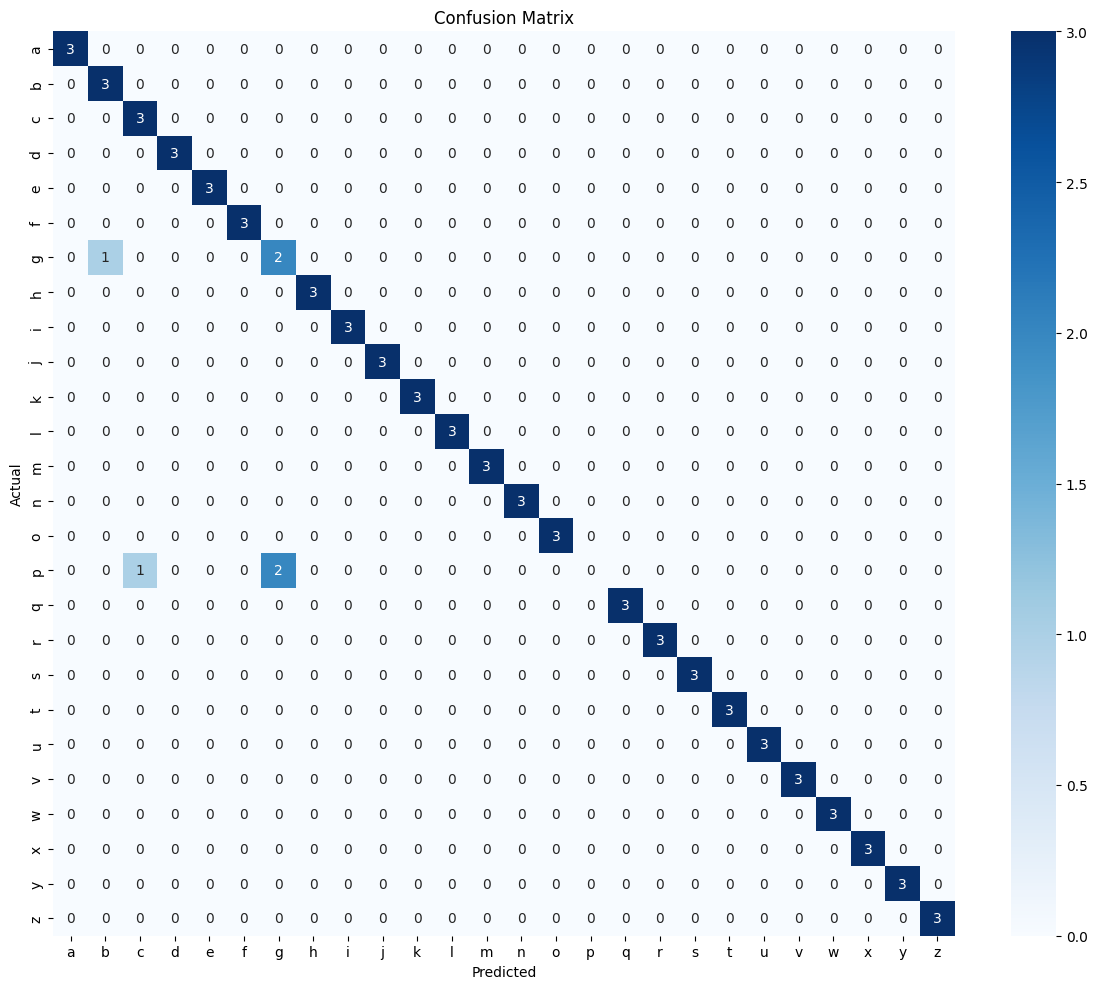

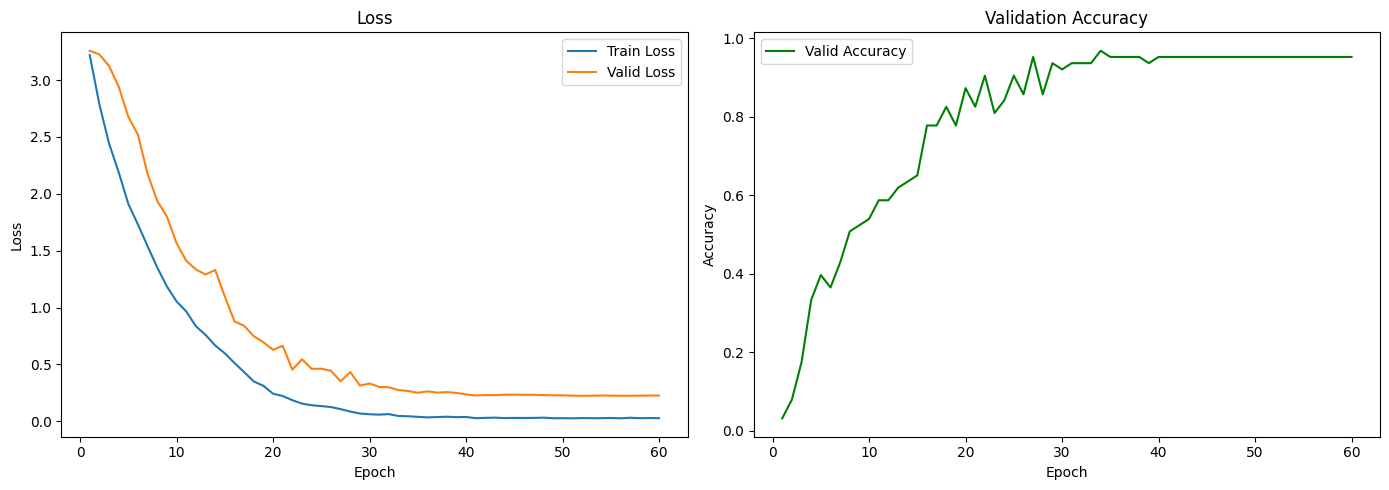


Evaluation for Region: jawa
Accuracy : 0.9103
Precision: 0.9448
Recall   : 0.9103
F1 Score : 0.9135

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         6
           b       1.00      0.50      0.67         6
           c       1.00      1.00      1.00         6
           d       0.60      1.00      0.75         6
           e       1.00      0.83      0.91         6
           f       1.00      0.67      0.80         6
           g       0.86      1.00      0.92         6
           h       1.00      0.83      0.91         6
           i       1.00      0.83      0.91         6
           j       1.00      1.00      1.00         6
           k       1.00      1.00      1.00         6
           l       1.00      0.83      0.91         6
           m       1.00      1.00      1.00         6
           n       1.00      1.00      1.00         6
           o       1.00      1.00      1.00         6
          

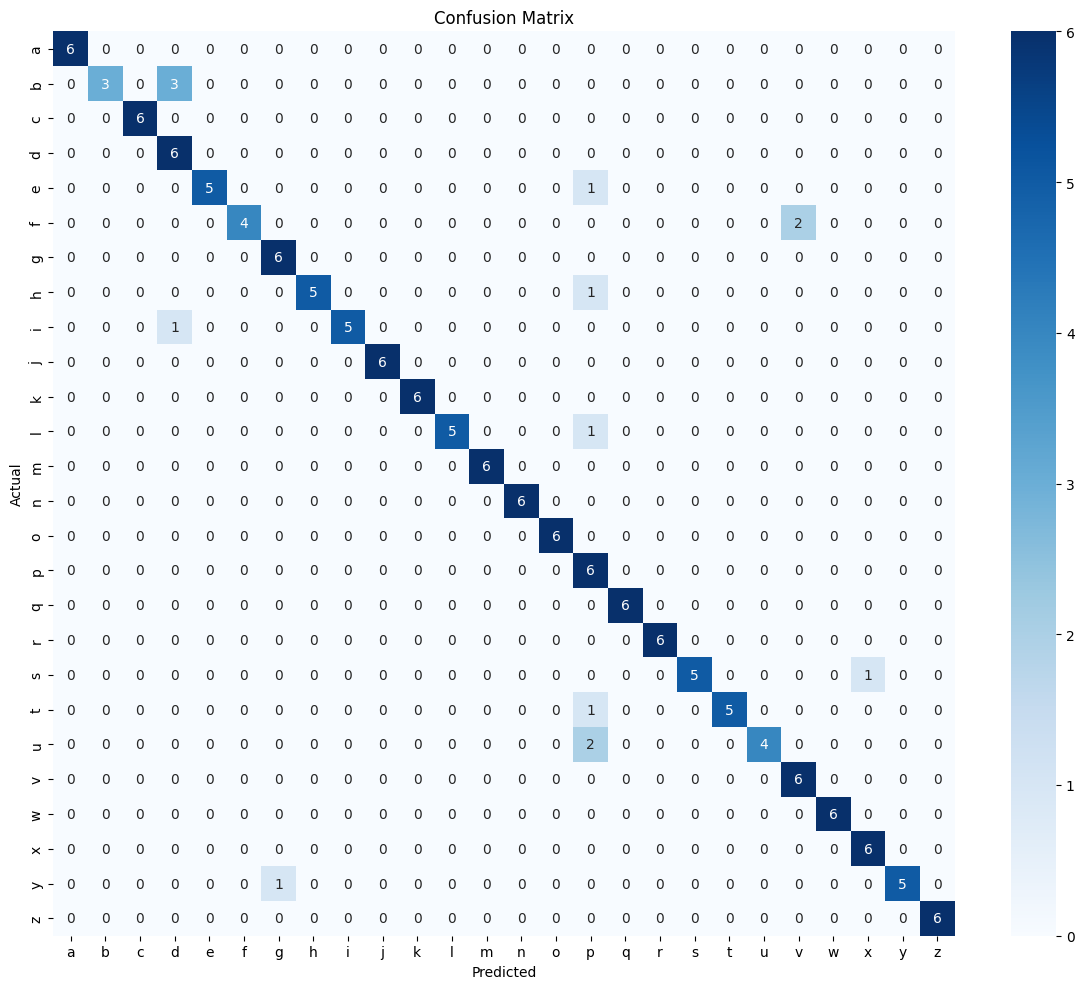

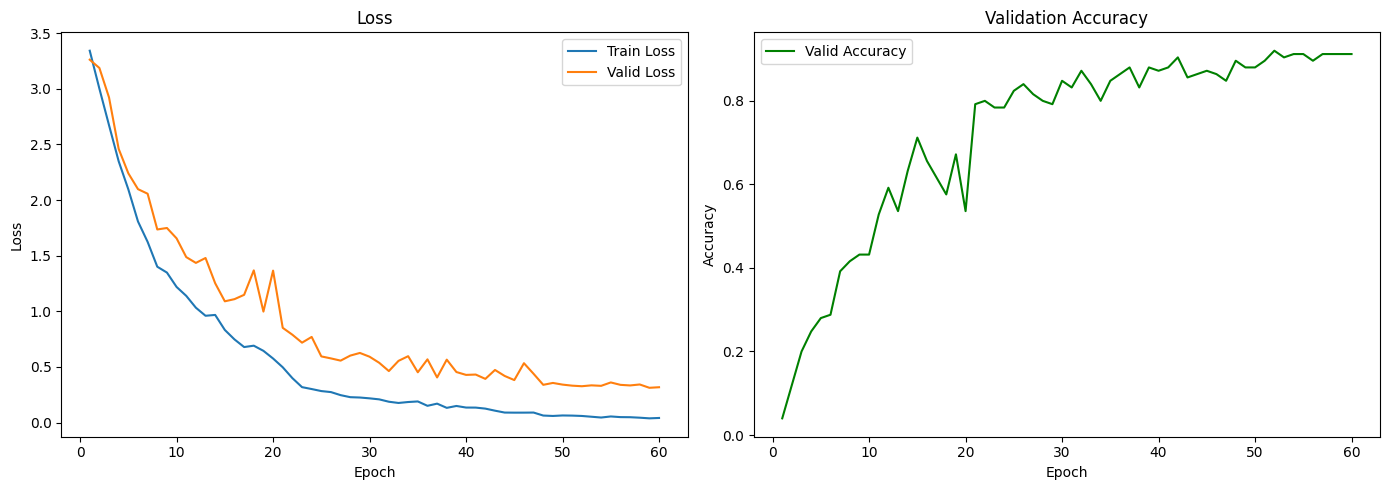


Evaluation for Region: bali
Accuracy : 0.8205
Precision: 0.8637
Recall   : 0.8205
F1 Score : 0.8102

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       0.43      1.00      0.60         3
           c       0.75      1.00      0.86         3
           d       0.60      1.00      0.75         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      0.33      0.50         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       0.50      0.33      0.40         3
           k       1.00      0.33      0.50         3
           l       1.00      0.67      0.80         3
           m       1.00      1.00      1.00         3
           n       1.00      0.67      0.80         3
           o       1.00      1.00      1.00         3
          

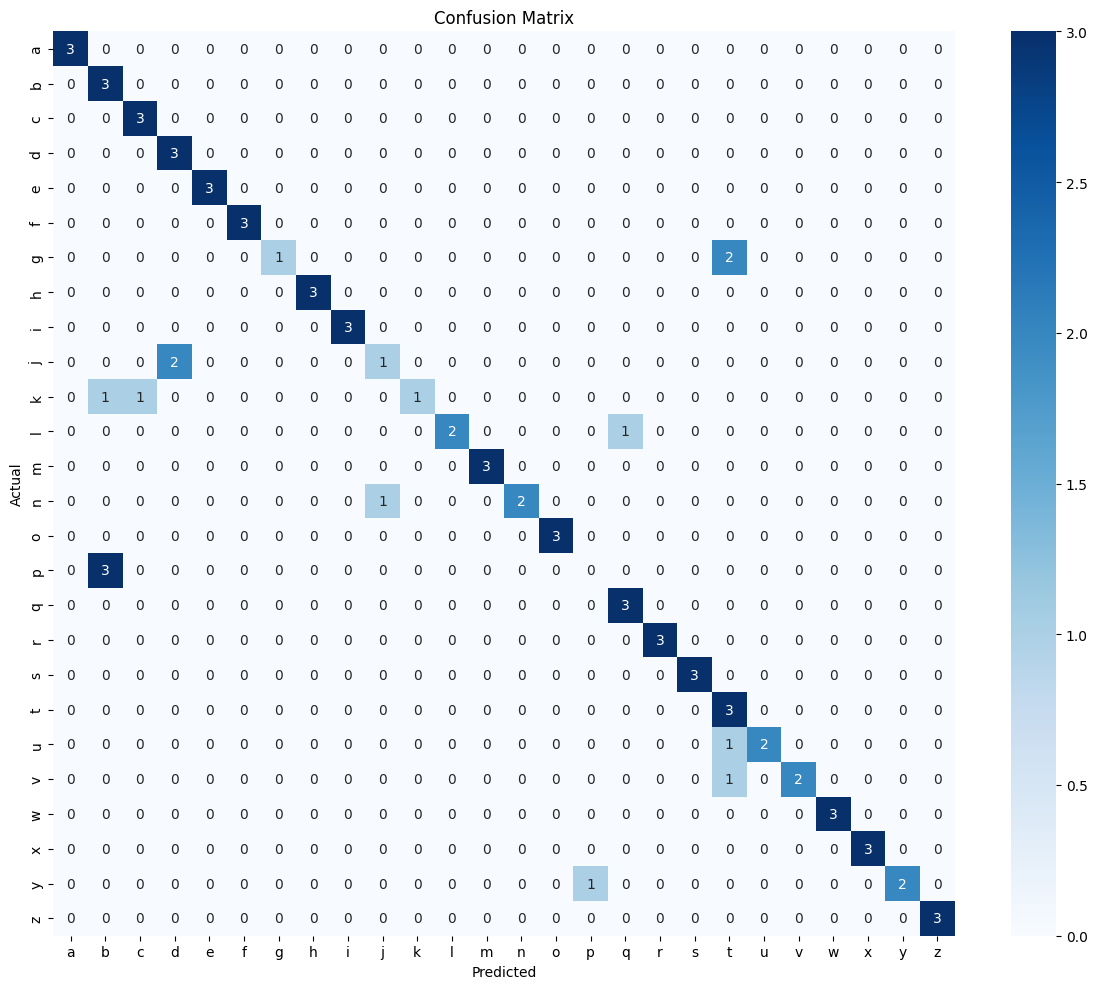

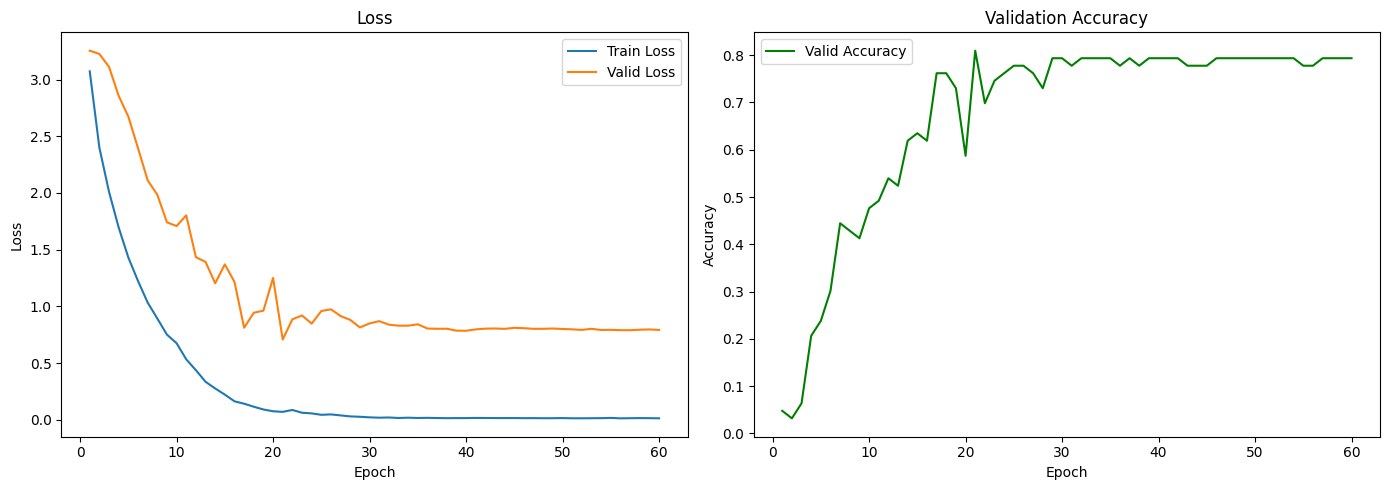


Evaluation for Region: madura
Accuracy : 0.9487
Precision: 0.9396
Recall   : 0.9487
F1 Score : 0.9385

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       0.43      1.00      0.60         3
           f       1.00      1.00      1.00         3
           g       1.00      1.00      1.00         3
           h       1.00      1.00      1.00         3
           i       1.00      0.67      0.80         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
        

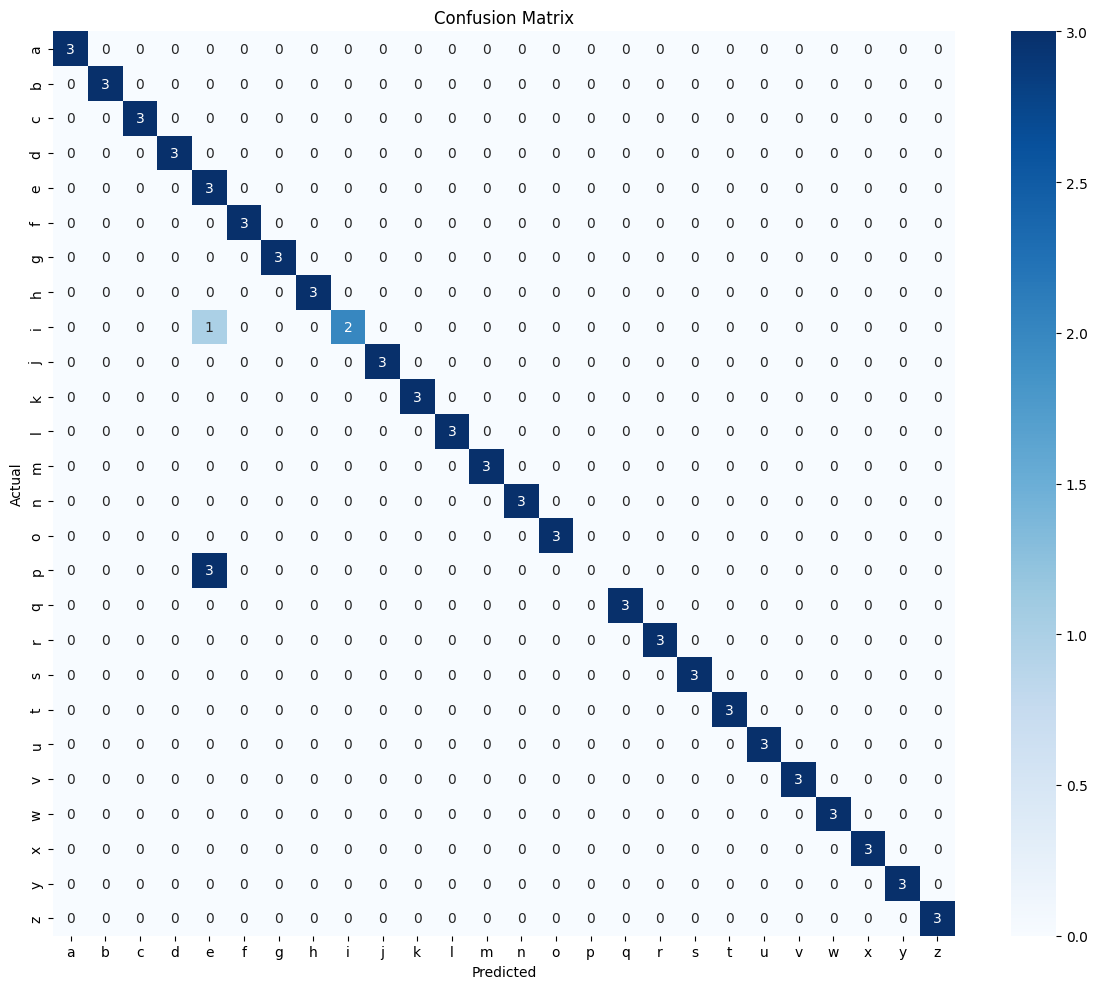

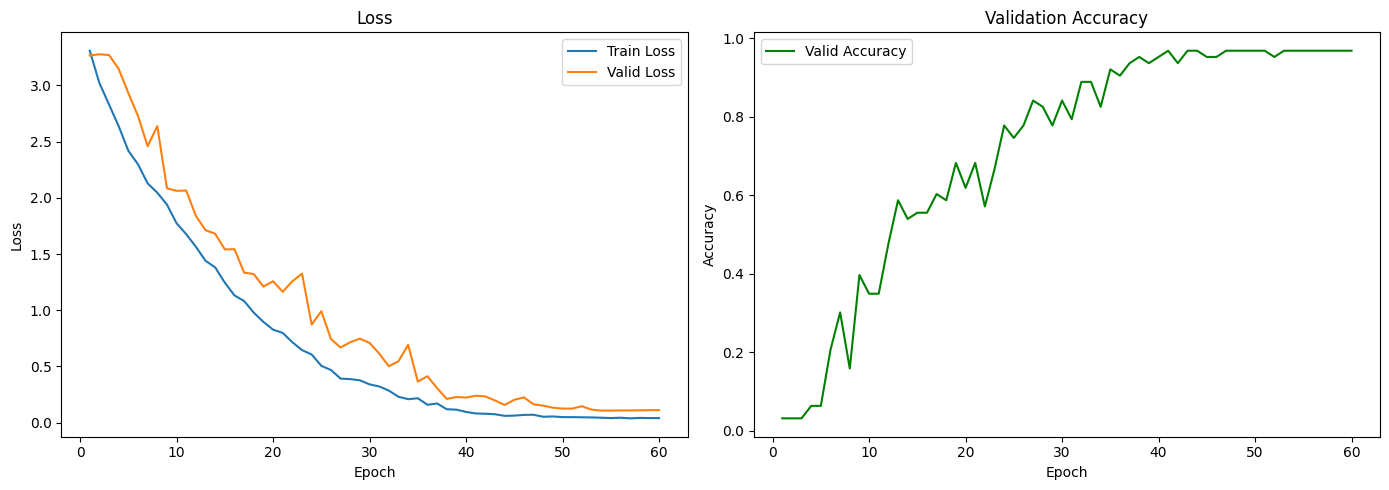


Evaluation for Region: papua
Accuracy : 0.9904
Precision: 0.9923
Recall   : 0.9904
F1 Score : 0.9902

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         4
           b       1.00      1.00      1.00         4
           c       1.00      1.00      1.00         4
           d       1.00      1.00      1.00         4
           e       1.00      1.00      1.00         4
           f       1.00      1.00      1.00         4
           g       1.00      1.00      1.00         4
           h       1.00      0.75      0.86         4
           i       1.00      1.00      1.00         4
           j       1.00      1.00      1.00         4
           k       1.00      1.00      1.00         4
           l       1.00      1.00      1.00         4
           m       1.00      1.00      1.00         4
           n       1.00      1.00      1.00         4
           o       1.00      1.00      1.00         4
         

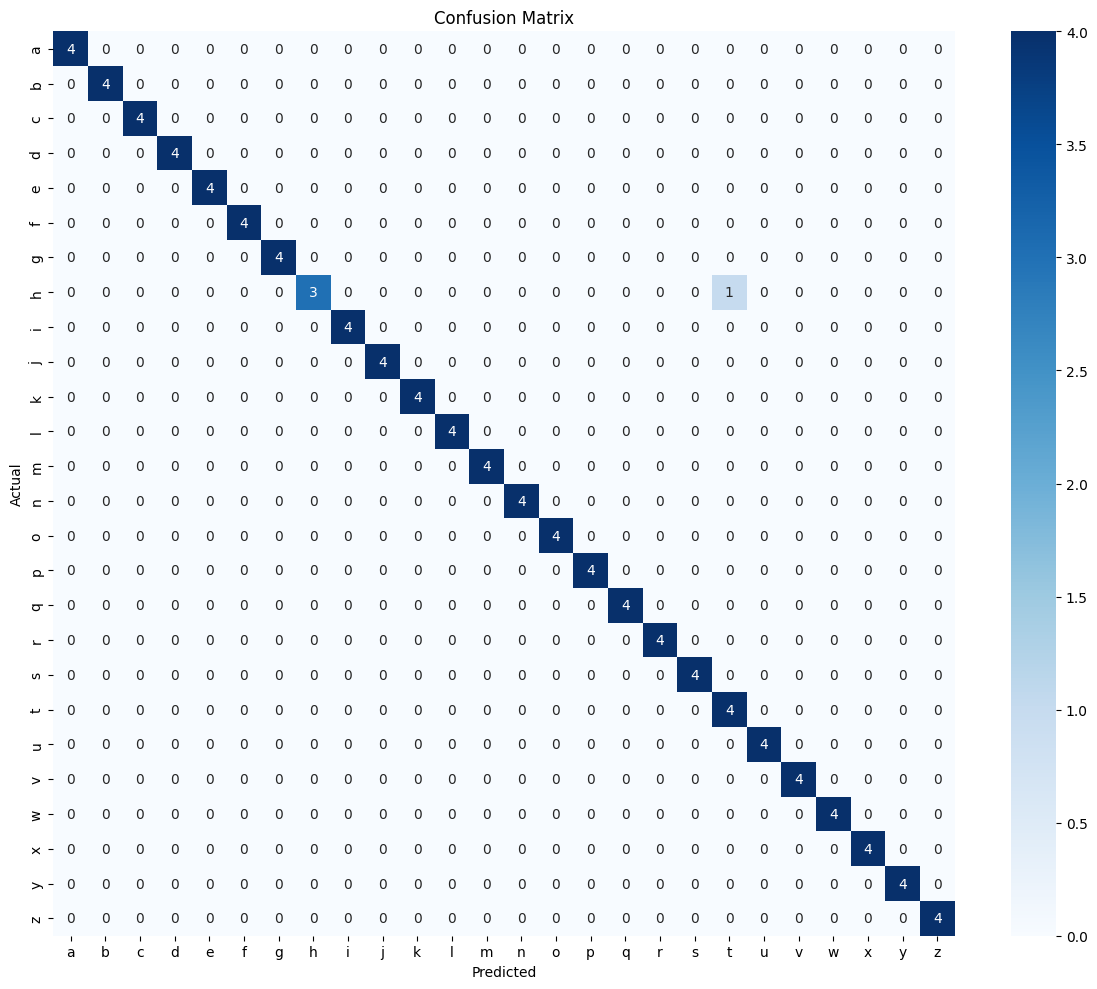

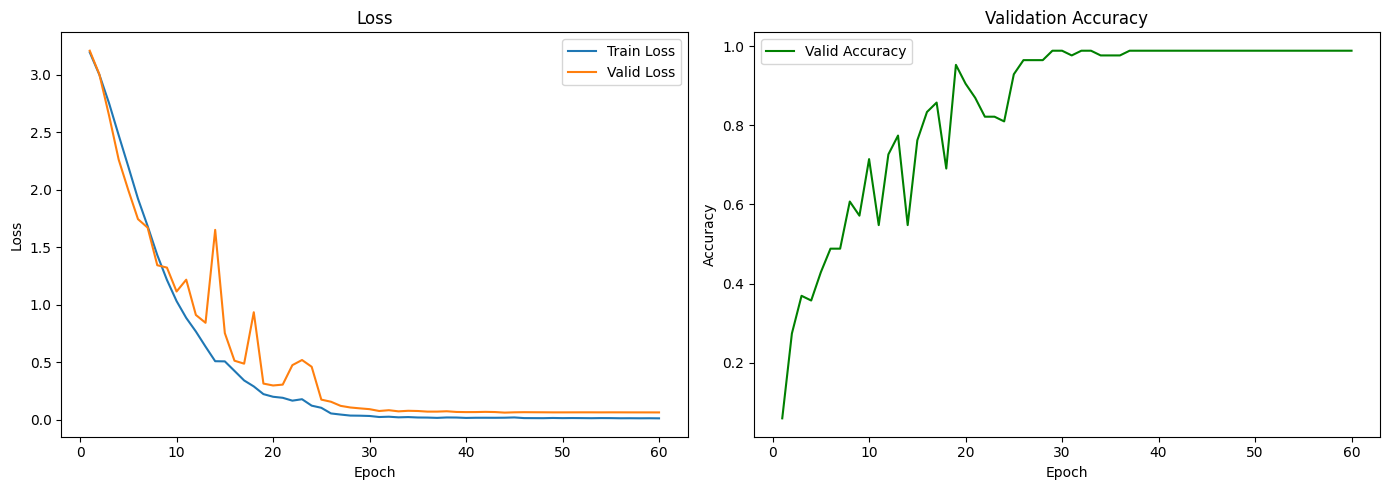

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs+1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs+1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs+1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def evaluate_all_regions(region_results, cnn_models_by_region):
    for region_name, region_data in region_results.items():
        print(f"\nEvaluation for Region: {region_name}")
        model = cnn_models_by_region[region_name]['model']
        label_encoder = cnn_models_by_region[region_name]['label_encoder']
        evaluate_model(model, region_data['X_test'], region_data['y_test'], label_encoder)
        plot_training_history(model)

if __name__ == '__main__':
    evaluate_all_regions(region_results, cnn_models_by_region)

## RNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import numpy as np
import os, contextlib
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import CosineAnnealingLR
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, EpochScoring, Callback
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\n[LR Reduction] Reducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class RNN_GRU(nn.Module):
    def __init__(self, input_dim, num_classes,
                 gru_hidden_size=320, num_layers=2,
                 attention_heads=4, dense_size=512,
                 dropout=0.3, bidirectional=True,
                 activation_fn='mish'):
        super().__init__()

        self.activation = (
            nn.ReLU() if activation_fn == 'relu'
            else nn.GELU() if activation_fn == 'gelu'
            else nn.Mish()
        )

        self.gru = nn.GRU(
            input_dim,
            gru_hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(
            embed_dim=gru_hidden_size * (2 if bidirectional else 1),
            num_heads=attention_heads,
            dropout=dropout,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(gru_hidden_size * (2 if bidirectional else 1), dense_size),
            self.activation,
            nn.LayerNorm(dense_size),
            nn.Dropout(dropout),
            nn.Linear(dense_size, num_classes)
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attn_out, _ = self.attention(gru_out, gru_out, gru_out)
        pooled = attn_out.mean(dim=1)
        return self.classifier(pooled)

def gru_optuna(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    X_train_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_train]
    X_val_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_val]
    X_test_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_test]

    X_train_pad = pad_sequence(X_train_tensor, batch_first=True).numpy()
    X_val_pad = pad_sequence(X_val_tensor, batch_first=True).numpy()
    X_test_pad = pad_sequence(X_test_tensor, batch_first=True).numpy()

    def objective(trial):
        input_dim = X_train_pad.shape[-1]
        num_classes = len(label_encoder.classes_)

        model = RNN_GRU(
            input_dim=input_dim,
            num_classes=num_classes,
            gru_hidden_size=trial.suggest_categorical('gru_hidden_size', [256, 320, 384]),
            num_layers=trial.suggest_int('num_layers', 1, 3),
            attention_heads=trial.suggest_categorical('attention_heads', [2, 4, 8]),
            dense_size=trial.suggest_categorical('dense_size', [384, 512, 640]),
            dropout=trial.suggest_float('dropout', 0.2, 0.4, step=0.05),
            bidirectional=trial.suggest_categorical('bidirectional', [True, False]),
            activation_fn=trial.suggest_categorical('activation_fn', ['relu', 'gelu', 'mish'])
        )

        net = NeuralNetClassifier(
            module=model,
            max_epochs=60,
            batch_size=32,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
            device='cuda' if torch.cuda.is_available() else 'cpu',
            train_split=predefined_split(
                torch.utils.data.TensorDataset(
                    torch.FloatTensor(X_val_pad),
                    torch.LongTensor(y_val)
                )
            ),
            callbacks=[
                ('adapt', AdaptiveEarlyStopping(patience=5)),
                ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
                ('score', EpochScoring('accuracy', name='valid_acc'))
            ],
            verbose=0
        )

        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                net.fit(X_train_pad.astype(np.float32), np.array(y_train).astype(np.longlong))

        for epoch, acc in enumerate(net.history[:, 'valid_acc']):
            trial.report(acc, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return max(net.history[:, 'valid_acc'])

    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_params)

    best_params = study.best_params
    input_dim = X_train_pad.shape[-1]
    num_classes = len(label_encoder.classes_)

    final_model = RNN_GRU(
        input_dim=input_dim,
        num_classes=num_classes,
        gru_hidden_size=best_params['gru_hidden_size'],
        num_layers=best_params['num_layers'],
        attention_heads=best_params['attention_heads'],
        dense_size=best_params['dense_size'],
        dropout=best_params['dropout'],
        bidirectional=best_params['bidirectional'],
        activation_fn=best_params['activation_fn']
    )

    final_net = NeuralNetClassifier(
        final_model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(
            torch.utils.data.TensorDataset(
                torch.FloatTensor(X_val_pad),
                torch.LongTensor(y_val)
            )
        ),
        callbacks=[
            ('adapt', AdaptiveEarlyStopping(patience=5)),
            ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
            ('score', EpochScoring('accuracy', name='valid_acc'))
        ],
        verbose=1
    )

    final_net.fit(X_train_pad.astype(np.float32), np.array(y_train).astype(np.longlong))
    return final_net

def train_all_regions(region_results):
    rnn_models_by_region = {}
    for region_name, region_data in region_results.items():
        print(f"\nTraining for Region: {region_name}")

        best_model = gru_optuna(
            region_data['X_train'],
            region_data['y_train'],
            region_data['X_test'],
            region_data['y_test'],
            region_data['label_encoder']
        )

        X_test_tensor = [torch.tensor(x, dtype=torch.float32) for x in region_data['X_test']]
        X_test_pad = pad_sequence(X_test_tensor, batch_first=True).numpy()
        y_pred = best_model.predict(X_test_pad.astype(np.float32))

        print("\nFinal Classification Report:")
        print(classification_report(
            region_data['y_test'], y_pred,
            target_names=region_data['label_encoder'].classes_,
            zero_division=0
        ))

        rnn_models_by_region[region_name] = {
            'model': best_model,
            'label_encoder': region_data['label_encoder']
        }

    return rnn_models_by_region

if __name__ == '__main__':
    rnn_models_by_region = train_all_regions(region_results)

[I 2025-06-05 17:35:15,029] A new study created in memory with name: no-name-aafbfe30-f9fc-472d-8bd8-5c3733b7283c



Training for Region: batam


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-05 17:35:42,976] Trial 0 finished with value: 0.9841269841269841 and parameters: {'gru_hidden_size': 320, 'num_layers': 1, 'attention_heads': 8, 'dense_size': 640, 'dropout': 0.35000000000000003, 'bidirectional': True, 'activation_fn': 'relu'}. Best is trial 0 with value: 0.9841269841269841.
[I 2025-06-05 17:35:58,858] Trial 1 finished with value: 0.9682539682539683 and parameters: {'gru_hidden_size': 320, 'num_layers': 1, 'attention_heads': 2, 'dense_size': 384, 'dropout': 0.35000000000000003, 'bidirectional': False, 'activation_fn': 'gelu'}. Best is trial 0 with value: 0.9841269841269841.
[I 2025-06-05 17:36:42,084] Trial 2 finished with value: 0.9682539682539683 and parameters: {'gru_hidden_size': 320, 'num_layers': 2, 'attention_heads': 4, 'dense_size': 640, 'dropout': 0.35000000000000003, 'bidirectional': True, 'activation_fn': 'gelu'}. Best is trial 0 with value: 0.9841269841269841.
[I 2025-06-05 17:37:12,221] Trial 3 finished with value: 0.9365079365079365 and paramet

[I 2025-06-05 17:50:55,077] A new study created in memory with name: no-name-98c29af6-95b4-43e0-8963-a7055ee487ec



Final Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       0.60      1.00      0.75         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
           p       0.00      0.00      0.00         3
           q       1.00      1.00      1.00        

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-05 17:52:39,648] Trial 0 finished with value: 1.0 and parameters: {'gru_hidden_size': 256, 'num_layers': 3, 'attention_heads': 4, 'dense_size': 384, 'dropout': 0.25, 'bidirectional': False, 'activation_fn': 'mish'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 17:54:46,735] Trial 1 finished with value: 1.0 and parameters: {'gru_hidden_size': 320, 'num_layers': 1, 'attention_heads': 8, 'dense_size': 512, 'dropout': 0.35000000000000003, 'bidirectional': True, 'activation_fn': 'mish'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 17:58:53,896] Trial 2 finished with value: 0.976 and parameters: {'gru_hidden_size': 320, 'num_layers': 3, 'attention_heads': 4, 'dense_size': 384, 'dropout': 0.35000000000000003, 'bidirectional': True, 'activation_fn': 'mish'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 18:00:28,777] Trial 3 finished with value: 1.0 and parameters: {'gru_hidden_size': 384, 'num_layers': 2, 'attention_heads': 4, 'dense_size': 512, 'dropout': 0.2, 'bidirectional

[I 2025-06-05 19:01:00,511] A new study created in memory with name: no-name-5f21973e-7914-4f95-b894-9c0ecad515f1



Final Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         6
           b       1.00      0.83      0.91         6
           c       1.00      1.00      1.00         6
           d       0.86      1.00      0.92         6
           e       1.00      0.83      0.91         6
           f       1.00      1.00      1.00         6
           g       1.00      1.00      1.00         6
           h       1.00      1.00      1.00         6
           i       1.00      1.00      1.00         6
           j       1.00      1.00      1.00         6
           k       1.00      1.00      1.00         6
           l       0.86      1.00      0.92         6
           m       1.00      1.00      1.00         6
           n       1.00      1.00      1.00         6
           o       1.00      1.00      1.00         6
           p       1.00      0.83      0.91         6
           q       0.86      1.00      0.92        

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-05 19:01:44,344] Trial 0 finished with value: 0.9523809523809523 and parameters: {'gru_hidden_size': 384, 'num_layers': 2, 'attention_heads': 8, 'dense_size': 384, 'dropout': 0.35000000000000003, 'bidirectional': True, 'activation_fn': 'gelu'}. Best is trial 0 with value: 0.9523809523809523.
[I 2025-06-05 19:02:10,243] Trial 1 finished with value: 0.9365079365079365 and parameters: {'gru_hidden_size': 320, 'num_layers': 3, 'attention_heads': 2, 'dense_size': 384, 'dropout': 0.30000000000000004, 'bidirectional': False, 'activation_fn': 'mish'}. Best is trial 0 with value: 0.9523809523809523.
[I 2025-06-05 19:02:27,980] Trial 2 finished with value: 0.9682539682539683 and parameters: {'gru_hidden_size': 320, 'num_layers': 1, 'attention_heads': 8, 'dense_size': 512, 'dropout': 0.35000000000000003, 'bidirectional': False, 'activation_fn': 'gelu'}. Best is trial 2 with value: 0.9682539682539683.
[I 2025-06-05 19:03:10,124] Trial 3 finished with value: 0.9682539682539683 and parame

[I 2025-06-05 19:15:37,572] A new study created in memory with name: no-name-1b0ad2ad-7f60-4f49-9086-b2ce8f4f0788



Final Classification Report:
              precision    recall  f1-score   support

           a       0.75      1.00      0.86         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      1.00      1.00         3
           h       1.00      1.00      1.00         3
           i       0.75      1.00      0.86         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
           p       0.00      0.00      0.00         3
           q       1.00      1.00      1.00        

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-05 19:15:52,149] Trial 0 finished with value: 0.9682539682539683 and parameters: {'gru_hidden_size': 256, 'num_layers': 1, 'attention_heads': 4, 'dense_size': 512, 'dropout': 0.35000000000000003, 'bidirectional': False, 'activation_fn': 'mish'}. Best is trial 0 with value: 0.9682539682539683.
[I 2025-06-05 19:16:39,455] Trial 1 finished with value: 0.9682539682539683 and parameters: {'gru_hidden_size': 384, 'num_layers': 2, 'attention_heads': 8, 'dense_size': 384, 'dropout': 0.25, 'bidirectional': True, 'activation_fn': 'gelu'}. Best is trial 0 with value: 0.9682539682539683.
[I 2025-06-05 19:16:52,759] Trial 2 finished with value: 0.9682539682539683 and parameters: {'gru_hidden_size': 256, 'num_layers': 1, 'attention_heads': 2, 'dense_size': 640, 'dropout': 0.25, 'bidirectional': False, 'activation_fn': 'mish'}. Best is trial 0 with value: 0.9682539682539683.
[I 2025-06-05 19:17:21,060] Trial 3 finished with value: 0.9682539682539683 and parameters: {'gru_hidden_size': 256,

[I 2025-06-05 19:29:29,042] A new study created in memory with name: no-name-8c1e9657-1958-473f-a497-0610131c7da8



Final Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      1.00      1.00         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
           p       0.00      0.00      0.00         3
           q       1.00      1.00      1.00        

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-05 19:29:49,481] Trial 0 finished with value: 1.0 and parameters: {'gru_hidden_size': 384, 'num_layers': 3, 'attention_heads': 8, 'dense_size': 512, 'dropout': 0.35000000000000003, 'bidirectional': False, 'activation_fn': 'gelu'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 19:30:05,178] Trial 1 finished with value: 1.0 and parameters: {'gru_hidden_size': 256, 'num_layers': 1, 'attention_heads': 4, 'dense_size': 384, 'dropout': 0.35000000000000003, 'bidirectional': True, 'activation_fn': 'relu'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 19:30:42,304] Trial 2 finished with value: 0.9880952380952381 and parameters: {'gru_hidden_size': 256, 'num_layers': 3, 'attention_heads': 2, 'dense_size': 640, 'dropout': 0.4, 'bidirectional': True, 'activation_fn': 'relu'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 19:30:58,315] Trial 3 finished with value: 1.0 and parameters: {'gru_hidden_size': 256, 'num_layers': 1, 'attention_heads': 8, 'dense_size': 384, 'dropout': 0.4, 'b


Evaluation for Region: batam
Accuracy : 0.9615
Precision: 0.9365
Recall   : 0.9615
F1 Score : 0.9464

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       0.60      1.00      0.75         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
         

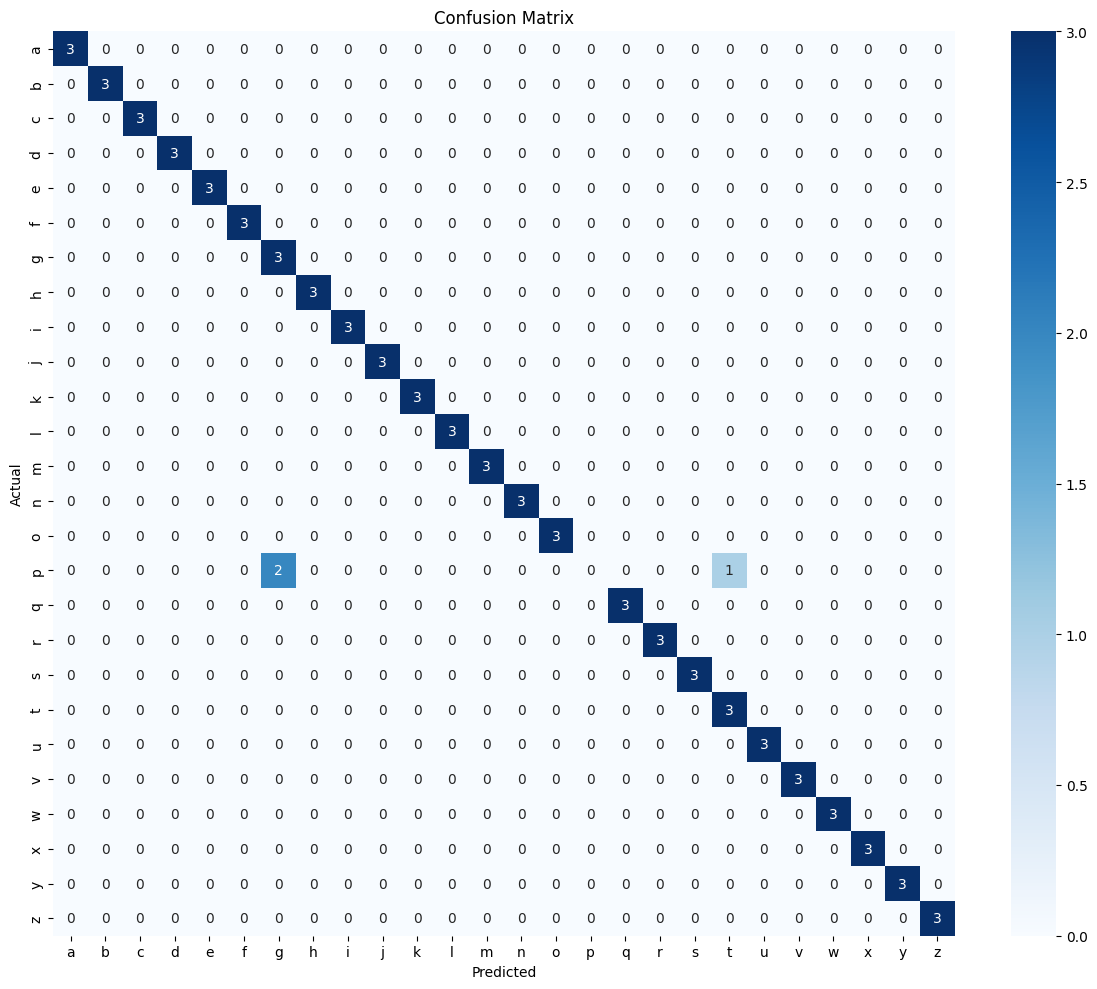

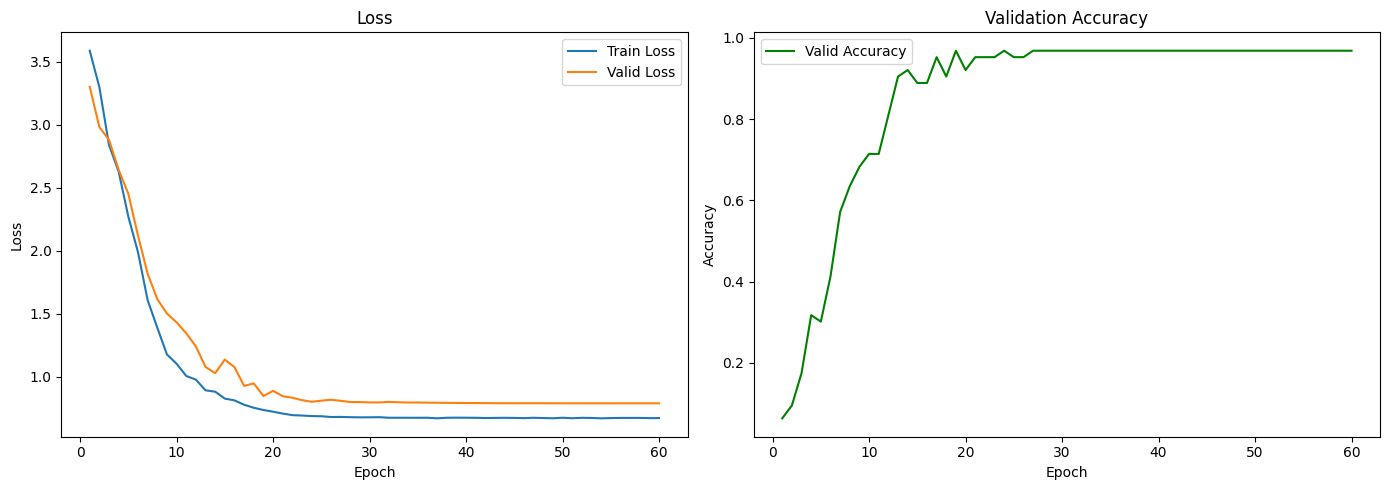


Evaluation for Region: jawa
Accuracy : 0.9615
Precision: 0.9675
Recall   : 0.9615
F1 Score : 0.9610

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         6
           b       1.00      0.83      0.91         6
           c       1.00      1.00      1.00         6
           d       0.86      1.00      0.92         6
           e       1.00      0.83      0.91         6
           f       1.00      1.00      1.00         6
           g       1.00      1.00      1.00         6
           h       1.00      1.00      1.00         6
           i       1.00      1.00      1.00         6
           j       1.00      1.00      1.00         6
           k       1.00      1.00      1.00         6
           l       0.86      1.00      0.92         6
           m       1.00      1.00      1.00         6
           n       1.00      1.00      1.00         6
           o       1.00      1.00      1.00         6
          

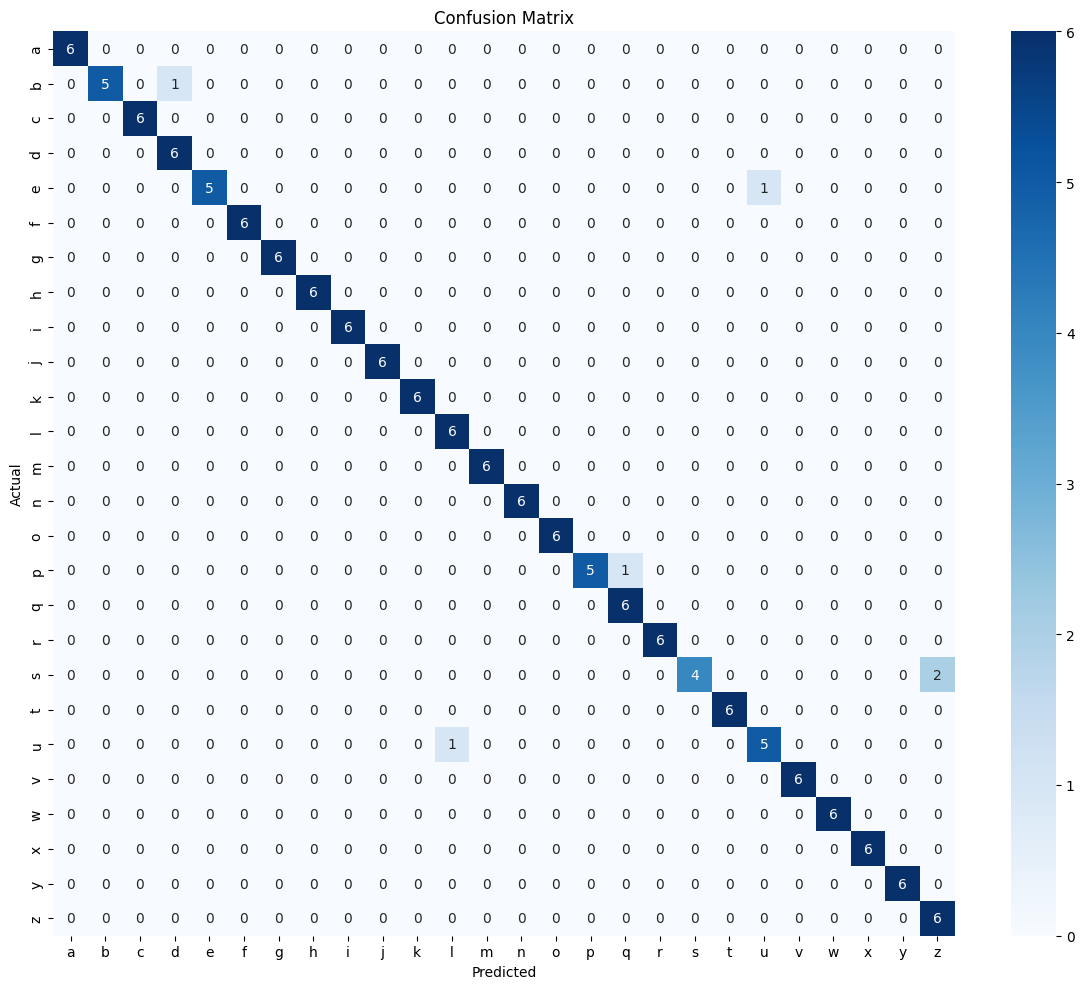

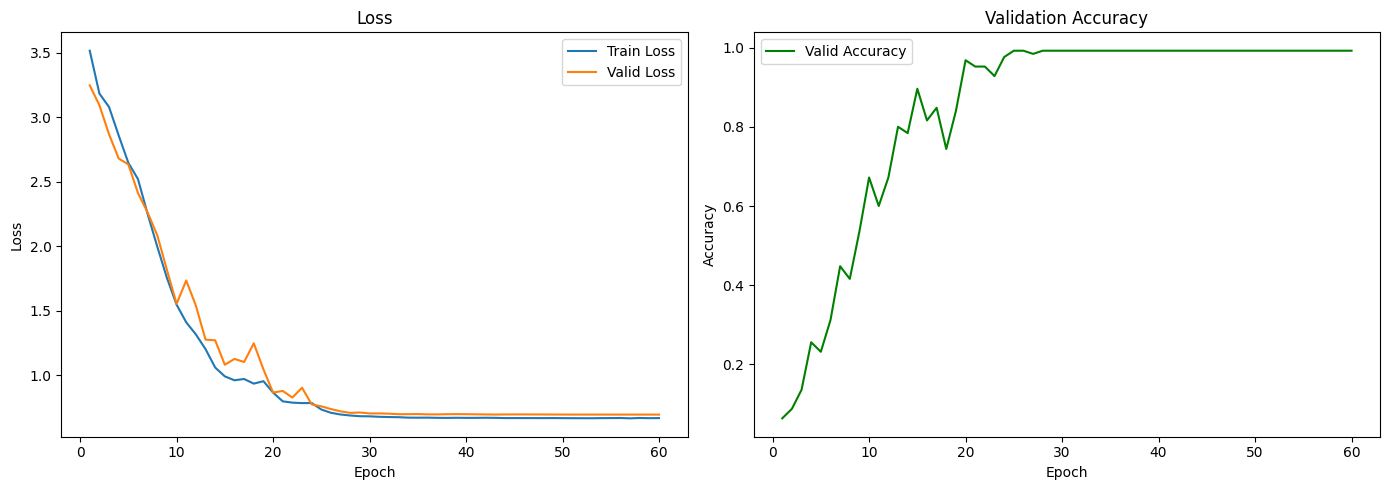


Evaluation for Region: bali
Accuracy : 0.9615
Precision: 0.9327
Recall   : 0.9615
F1 Score : 0.9451

Classification Report:
              precision    recall  f1-score   support

           a       0.75      1.00      0.86         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      1.00      1.00         3
           h       1.00      1.00      1.00         3
           i       0.75      1.00      0.86         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
          

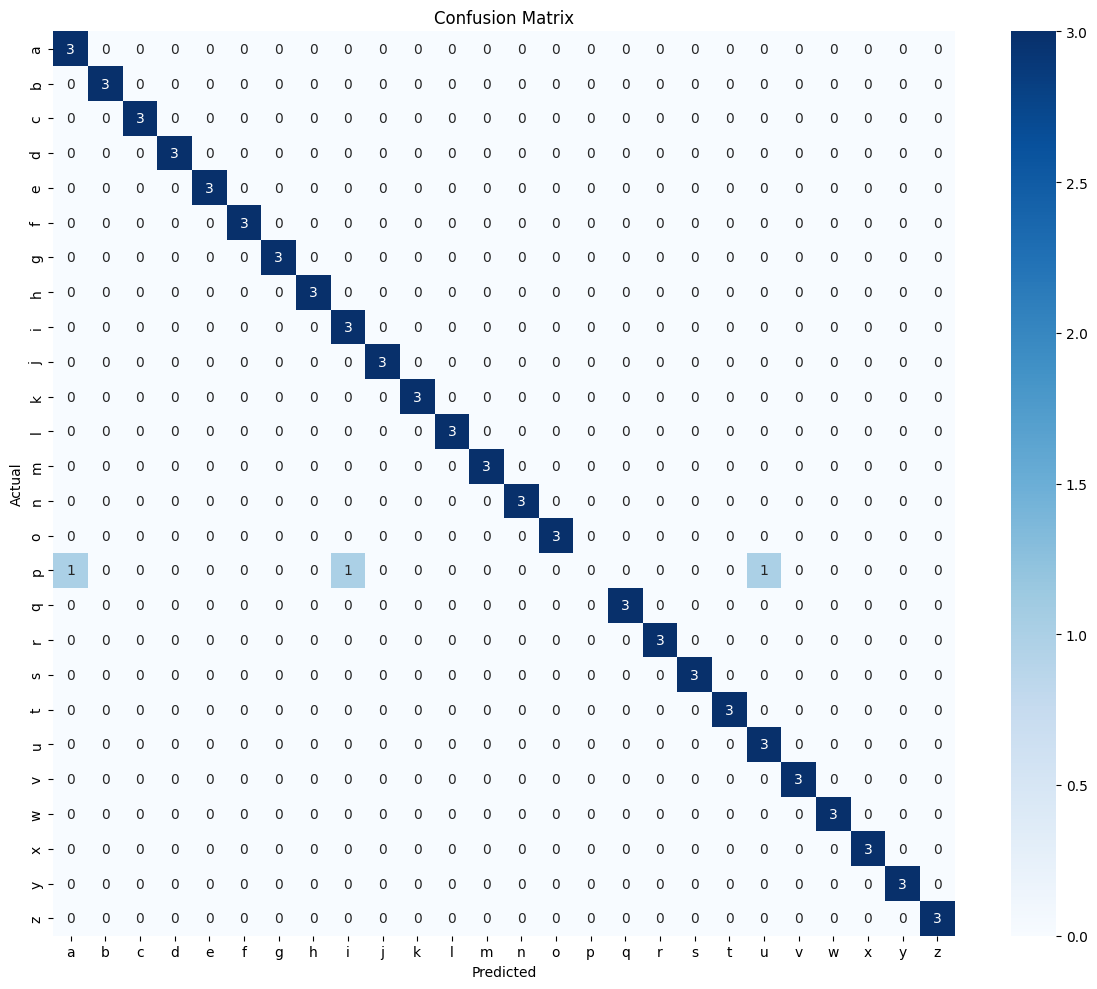

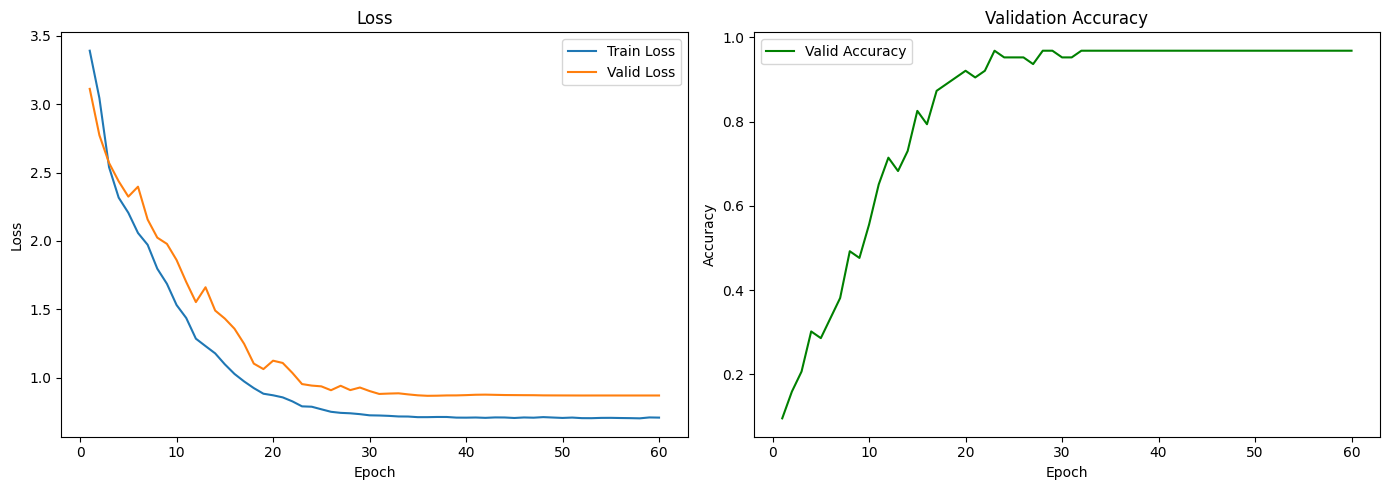


Evaluation for Region: madura
Accuracy : 0.9615
Precision: 0.9423
Recall   : 0.9615
F1 Score : 0.9487

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      1.00      1.00         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
        

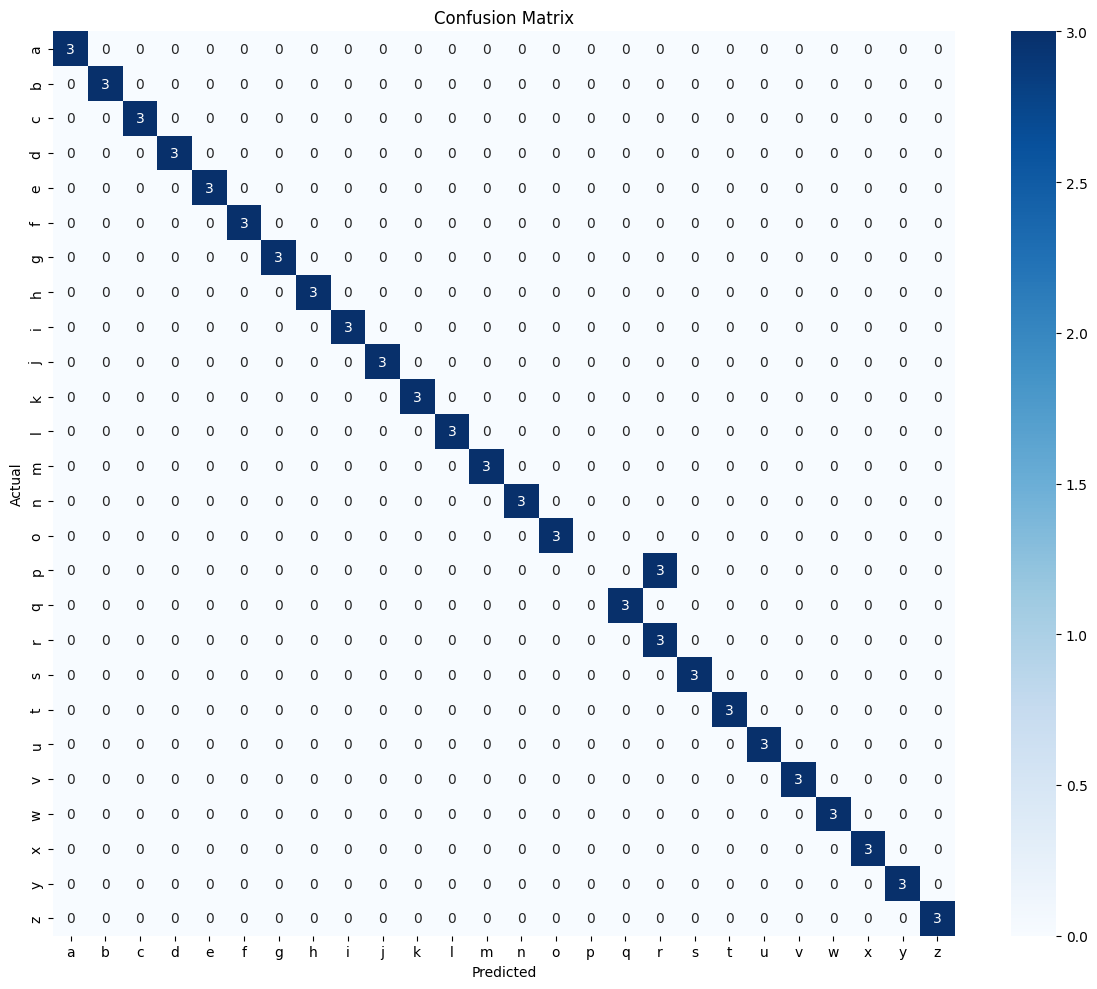

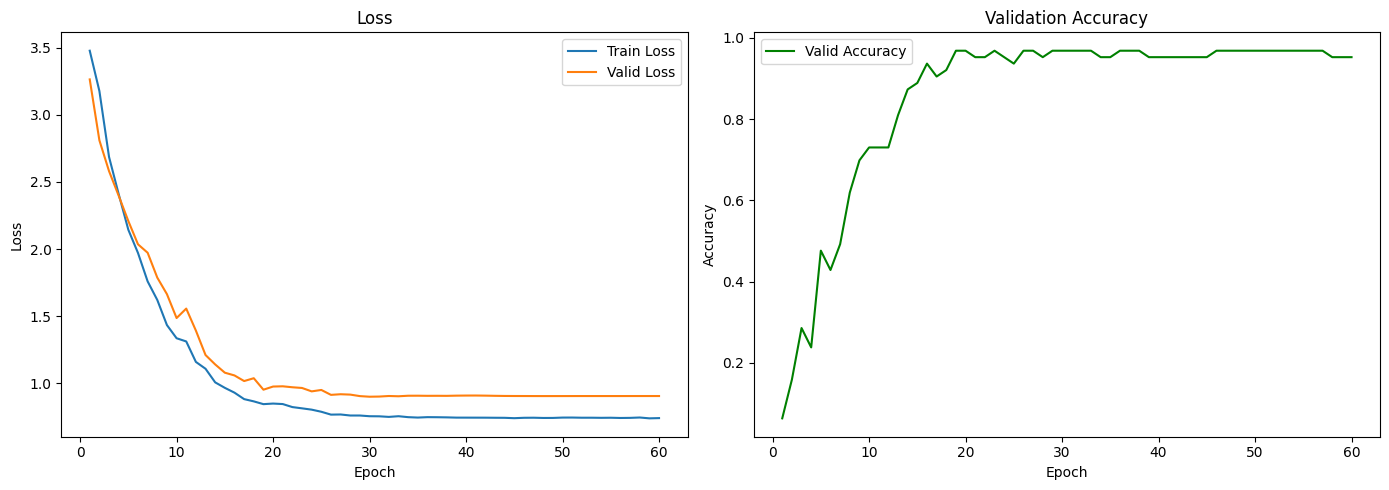


Evaluation for Region: papua
Accuracy : 0.9904
Precision: 0.9923
Recall   : 0.9904
F1 Score : 0.9902

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         4
           b       1.00      1.00      1.00         4
           c       1.00      1.00      1.00         4
           d       1.00      1.00      1.00         4
           e       1.00      1.00      1.00         4
           f       1.00      1.00      1.00         4
           g       1.00      1.00      1.00         4
           h       1.00      1.00      1.00         4
           i       1.00      1.00      1.00         4
           j       1.00      1.00      1.00         4
           k       1.00      0.75      0.86         4
           l       1.00      1.00      1.00         4
           m       0.80      1.00      0.89         4
           n       1.00      1.00      1.00         4
           o       1.00      1.00      1.00         4
         

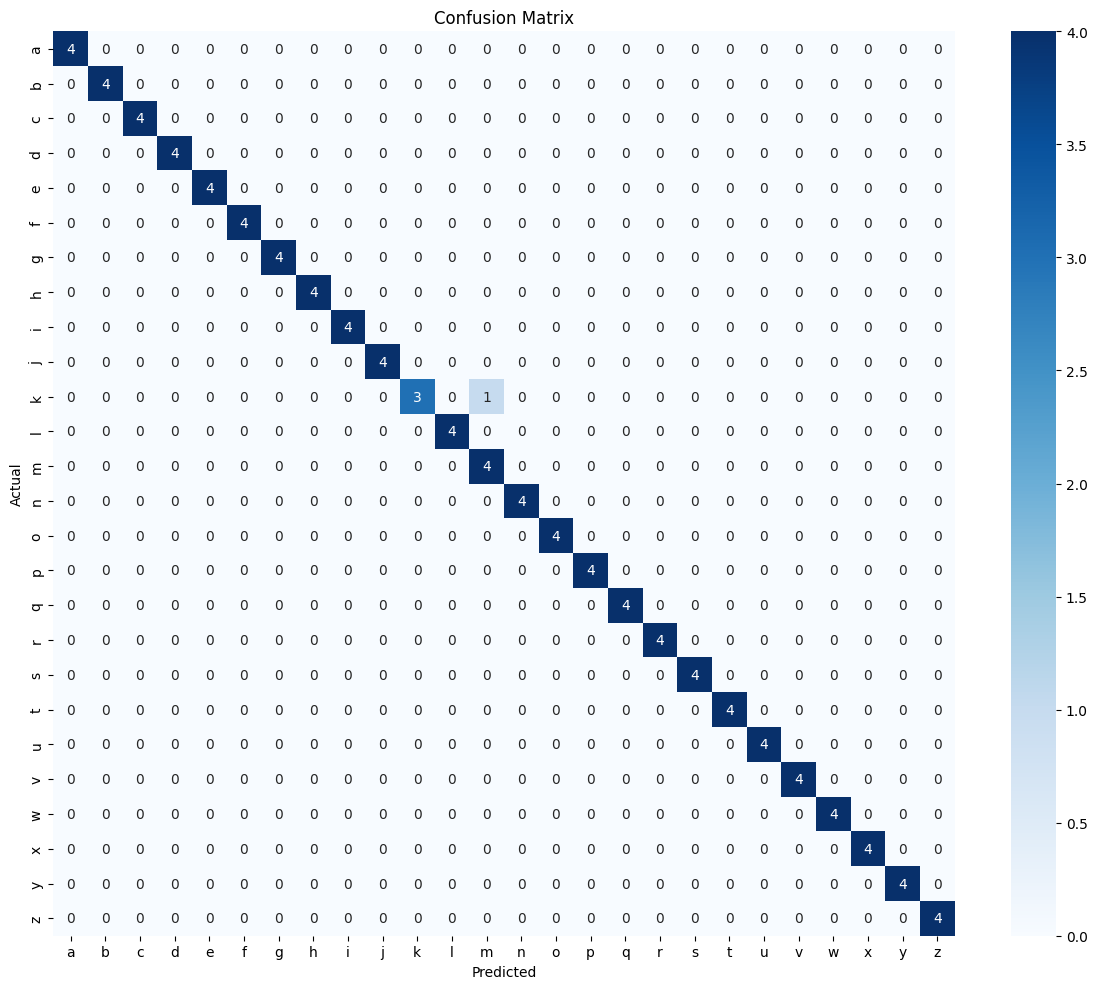

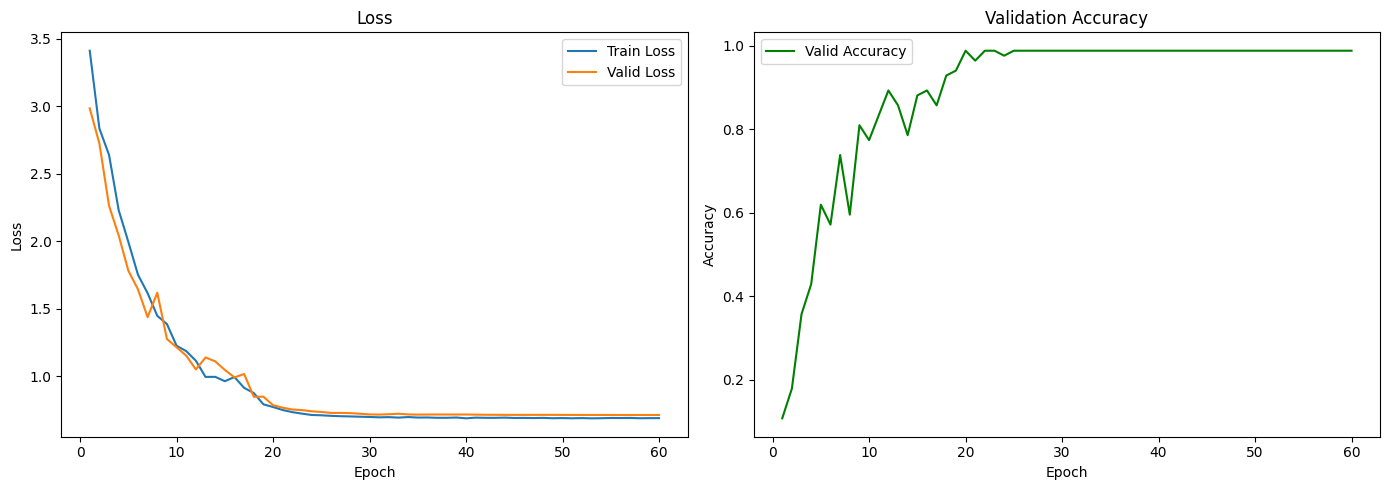

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs+1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs+1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs+1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def evaluate_all_regions(region_results, rnn_models_by_region):
    for region_name, region_data in region_results.items():
        print(f"\nEvaluation for Region: {region_name}")
        model = rnn_models_by_region[region_name]['model']
        label_encoder = rnn_models_by_region[region_name]['label_encoder']
        evaluate_model(model, region_data['X_test'], region_data['y_test'], label_encoder)
        plot_training_history(model)

if __name__ == '__main__':
    evaluate_all_regions(region_results, rnn_models_by_region)

## Transformer

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import optuna
import math
import os
import contextlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset
from skorch import NeuralNetClassifier
from skorch.callbacks import Callback, LRScheduler, EpochScoring
from skorch.helper import predefined_split

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\n[LR Reduction] Reducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        self.max_len = max_len
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        if seq_len > self.max_len:
            raise ValueError(f"Input sequence length {seq_len} exceeds maximum {self.max_len}")
        return x + self.pe[:seq_len, :]

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers, nhead, d_model, dim_feedforward, dropout, dense, activation, max_len):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dense),
            nn.ReLU(),
            nn.LayerNorm(dense),
            nn.Dropout(dropout),
            nn.Linear(dense, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)

def train_transformer(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    max_seq_len = X_train.shape[1]

    def objective(trial):
        d_model = trial.suggest_categorical('d_model', [64, 128, 256])
        valid_heads = [h for h in [2, 4, 8] if d_model % h == 0]
        if not valid_heads:
            raise optuna.exceptions.TrialPruned()

        model = TransformerClassifier(
            input_dim=X_train.shape[-1],
            num_classes=len(label_encoder.classes_),
            num_layers=trial.suggest_int('num_layers', 2, 4),
            nhead=trial.suggest_categorical('nhead', valid_heads),
            d_model=d_model,
            dim_feedforward=trial.suggest_categorical('dim_feedforward', [256, 512, 1024]),
            dropout=trial.suggest_float('dropout', 0.2, 0.4, step=0.05),
            dense=trial.suggest_categorical('dense', [128, 256, 512]),
            activation=trial.suggest_categorical('activation', ['relu', 'gelu']),
            max_len=max_seq_len
        )

        net = NeuralNetClassifier(
            module=model,
            max_epochs=60,
            batch_size=32,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            criterion=nn.CrossEntropyLoss(),
            device='cuda' if torch.cuda.is_available() else 'cpu',
            train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
            callbacks=[
                ('adapt', AdaptiveEarlyStopping(patience=5)),
                ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
                ('score', EpochScoring('accuracy', name='valid_acc'))
            ],
            verbose=0
        )

        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))

        for epoch, acc in enumerate(net.history[:, 'valid_acc']):
            trial.report(acc, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return max(net.history[:, 'valid_acc'])

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_trial.params)

    best_params = study.best_trial.params
    model = TransformerClassifier(
        input_dim=X_train.shape[-1],
        num_classes=len(label_encoder.classes_),
        **best_params,
        max_len=max_seq_len
    )

    final_net = NeuralNetClassifier(
        model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
        callbacks=[
            ('adapt', AdaptiveEarlyStopping(patience=5)),
            ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
            ('score', EpochScoring('accuracy', name='valid_acc'))
        ],
        verbose=1
    )

    final_net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
    return final_net

def train_all_regions(region_results):
    transformer_models_by_region = {}
    for region_name, region_data in region_results.items():
        print(f"\nTraining for Region: {region_name}")

        best_model = train_transformer(
            region_data['X_train'],
            region_data['y_train'],
            region_data['X_test'],
            region_data['y_test'],
            region_data['label_encoder']
        )

        y_pred = best_model.predict(region_data['X_test'].astype(np.float32))

        print("\nFinal Classification Report:")
        print(classification_report(
            region_data['y_test'], y_pred,
            target_names=region_data['label_encoder'].classes_,
            zero_division=0
        ))

        transformer_models_by_region[region_name] = {
            'model': best_model,
            'label_encoder': region_data['label_encoder']
        }

    return transformer_models_by_region

if __name__ == '__main__':
    transformer_models_by_region = train_all_regions(region_results)

[I 2025-06-05 19:40:53,517] A new study created in memory with name: no-name-b806ea51-4d48-44ee-9213-f98faac4ee9b



Training for Region: batam


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-05 19:41:11,013] Trial 0 finished with value: 0.8888888888888888 and parameters: {'d_model': 128, 'num_layers': 4, 'nhead': 8, 'dim_feedforward': 512, 'dropout': 0.35000000000000003, 'dense': 128, 'activation': 'relu'}. Best is trial 0 with value: 0.8888888888888888.
[I 2025-06-05 19:41:19,457] Trial 1 finished with value: 0.9206349206349206 and parameters: {'d_model': 64, 'num_layers': 3, 'nhead': 4, 'dim_feedforward': 512, 'dropout': 0.4, 'dense': 512, 'activation': 'relu'}. Best is trial 1 with value: 0.9206349206349206.
[I 2025-06-05 19:41:31,179] Trial 2 finished with value: 0.9365079365079365 and parameters: {'d_model': 64, 'num_layers': 3, 'nhead': 8, 'dim_feedforward': 512, 'dropout': 0.30000000000000004, 'dense': 256, 'activation': 'gelu'}. Best is trial 2 with value: 0.9365079365079365.
[I 2025-06-05 19:41:48,888] Trial 3 finished with value: 0.8888888888888888 and parameters: {'d_model': 256, 'num_layers': 3, 'nhead': 2, 'dim_feedforward': 1024, 'dropout': 0.30000

[I 2025-06-05 19:51:17,879] A new study created in memory with name: no-name-c5a87385-c552-4040-afa8-7eb13741e258


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-05 19:52:55,378] Trial 0 finished with value: 0.04 and parameters: {'d_model': 256, 'num_layers': 4, 'nhead': 4, 'dim_feedforward': 1024, 'dropout': 0.25, 'dense': 128, 'activation': 'relu'}. Best is trial 0 with value: 0.04.
[I 2025-06-05 19:53:30,128] Trial 1 finished with value: 0.92 and parameters: {'d_model': 64, 'num_layers': 4, 'nhead': 2, 'dim_feedforward': 512, 'dropout': 0.25, 'dense': 256, 'activation': 'relu'}. Best is trial 1 with value: 0.92.
[I 2025-06-05 19:54:33,478] Trial 2 finished with value: 0.976 and parameters: {'d_model': 256, 'num_layers': 2, 'nhead': 8, 'dim_feedforward': 1024, 'dropout': 0.2, 'dense': 512, 'activation': 'relu'}. Best is trial 2 with value: 0.976.
[I 2025-06-05 19:55:35,557] Trial 3 finished with value: 0.952 and parameters: {'d_model': 128, 'num_layers': 3, 'nhead': 8, 'dim_feedforward': 256, 'dropout': 0.4, 'dense': 256, 'activation': 'relu'}. Best is trial 2 with value: 0.976.
[I 2025-06-05 19:56:16,484] Trial 4 finished with val

[I 2025-06-05 20:41:00,364] A new study created in memory with name: no-name-8cc1a06d-cc2b-4665-a628-577475c72601



Final Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         6
           b       1.00      0.83      0.91         6
           c       1.00      0.83      0.91         6
           d       1.00      1.00      1.00         6
           e       1.00      1.00      1.00         6
           f       1.00      1.00      1.00         6
           g       0.86      1.00      0.92         6
           h       1.00      1.00      1.00         6
           i       1.00      1.00      1.00         6
           j       1.00      1.00      1.00         6
           k       1.00      0.83      0.91         6
           l       1.00      1.00      1.00         6
           m       0.86      1.00      0.92         6
           n       0.83      0.83      0.83         6
           o       1.00      1.00      1.00         6
           p       0.80      0.67      0.73         6
           q       1.00      1.00      1.00        

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-05 20:41:06,786] Trial 0 finished with value: 0.9206349206349206 and parameters: {'d_model': 64, 'num_layers': 3, 'nhead': 2, 'dim_feedforward': 512, 'dropout': 0.35000000000000003, 'dense': 256, 'activation': 'relu'}. Best is trial 0 with value: 0.9206349206349206.
[I 2025-06-05 20:41:13,904] Trial 1 finished with value: 0.9206349206349206 and parameters: {'d_model': 128, 'num_layers': 2, 'nhead': 2, 'dim_feedforward': 1024, 'dropout': 0.25, 'dense': 128, 'activation': 'relu'}. Best is trial 0 with value: 0.9206349206349206.
[I 2025-06-05 20:41:24,110] Trial 2 finished with value: 0.9523809523809523 and parameters: {'d_model': 128, 'num_layers': 4, 'nhead': 2, 'dim_feedforward': 512, 'dropout': 0.4, 'dense': 512, 'activation': 'relu'}. Best is trial 2 with value: 0.9523809523809523.
[I 2025-06-05 20:41:30,227] Trial 3 finished with value: 0.9523809523809523 and parameters: {'d_model': 128, 'num_layers': 2, 'nhead': 4, 'dim_feedforward': 256, 'dropout': 0.2, 'dense': 128, 'a

[I 2025-06-05 20:49:28,053] A new study created in memory with name: no-name-cdbcd0e9-1ba6-4083-b44b-3817d964d7ef


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-05 20:49:37,842] Trial 0 finished with value: 0.9523809523809523 and parameters: {'d_model': 64, 'num_layers': 3, 'nhead': 4, 'dim_feedforward': 1024, 'dropout': 0.2, 'dense': 512, 'activation': 'relu'}. Best is trial 0 with value: 0.9523809523809523.
[I 2025-06-05 20:49:52,318] Trial 1 finished with value: 0.9206349206349206 and parameters: {'d_model': 256, 'num_layers': 3, 'nhead': 4, 'dim_feedforward': 256, 'dropout': 0.35000000000000003, 'dense': 128, 'activation': 'gelu'}. Best is trial 0 with value: 0.9523809523809523.
[I 2025-06-05 20:50:04,675] Trial 2 finished with value: 0.9365079365079365 and parameters: {'d_model': 64, 'num_layers': 4, 'nhead': 4, 'dim_feedforward': 1024, 'dropout': 0.30000000000000004, 'dense': 256, 'activation': 'gelu'}. Best is trial 0 with value: 0.9523809523809523.
[I 2025-06-05 20:50:16,432] Trial 3 finished with value: 0.8888888888888888 and parameters: {'d_model': 128, 'num_layers': 4, 'nhead': 4, 'dim_feedforward': 256, 'dropout': 0.25, 

[I 2025-06-05 20:57:58,744] A new study created in memory with name: no-name-d4188dd5-84e2-47cf-82f8-2e2e6aa794d1



Final Classification Report:
              precision    recall  f1-score   support

           a       0.43      1.00      0.60         3
           b       1.00      0.67      0.80         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      0.67      0.80         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      0.67      0.80         3
           n       0.75      1.00      0.86         3
           o       1.00      1.00      1.00         3
           p       0.00      0.00      0.00         3
           q       1.00      1.00      1.00        

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-05 20:58:10,098] Trial 0 finished with value: 1.0 and parameters: {'d_model': 256, 'num_layers': 3, 'nhead': 8, 'dim_feedforward': 512, 'dropout': 0.25, 'dense': 512, 'activation': 'gelu'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 20:58:15,618] Trial 1 finished with value: 0.9880952380952381 and parameters: {'d_model': 128, 'num_layers': 2, 'nhead': 2, 'dim_feedforward': 256, 'dropout': 0.25, 'dense': 256, 'activation': 'relu'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 20:58:21,038] Trial 2 finished with value: 1.0 and parameters: {'d_model': 64, 'num_layers': 2, 'nhead': 8, 'dim_feedforward': 256, 'dropout': 0.30000000000000004, 'dense': 128, 'activation': 'gelu'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 20:58:28,161] Trial 3 finished with value: 0.9880952380952381 and parameters: {'d_model': 128, 'num_layers': 3, 'nhead': 4, 'dim_feedforward': 256, 'dropout': 0.4, 'dense': 256, 'activation': 'relu'}. Best is trial 0 with value: 1.0.
[I 2025-06-05 20:58:3


Evaluation for Region: batam
Accuracy : 0.9615
Precision: 0.9365
Recall   : 0.9615
F1 Score : 0.9464

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       0.60      1.00      0.75         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
         

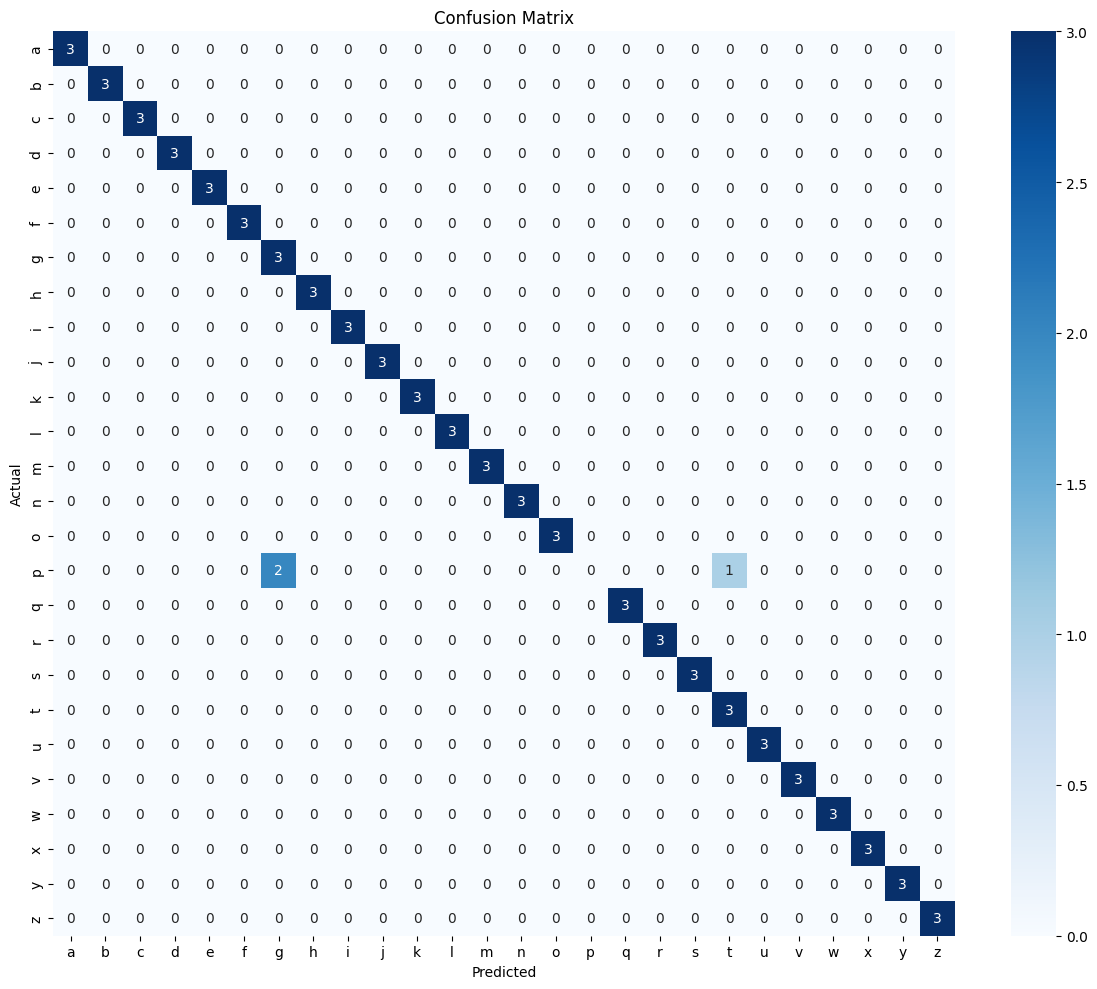

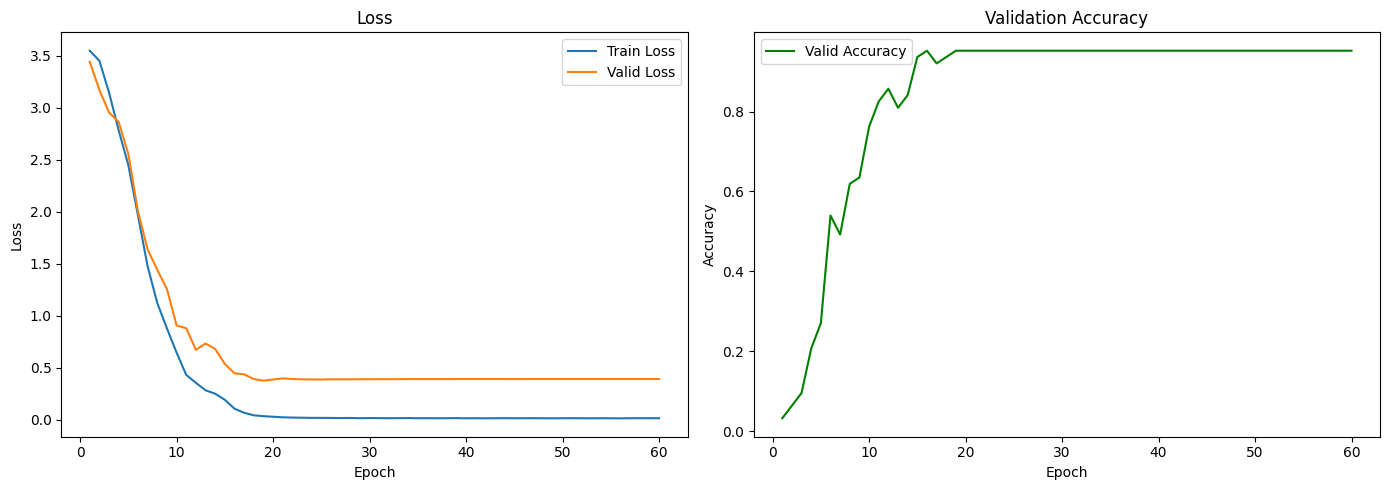


Evaluation for Region: jawa
Accuracy : 0.9359
Precision: 0.9388
Recall   : 0.9359
F1 Score : 0.9350

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         6
           b       1.00      0.83      0.91         6
           c       1.00      0.83      0.91         6
           d       1.00      1.00      1.00         6
           e       1.00      1.00      1.00         6
           f       1.00      1.00      1.00         6
           g       0.86      1.00      0.92         6
           h       1.00      1.00      1.00         6
           i       1.00      1.00      1.00         6
           j       1.00      1.00      1.00         6
           k       1.00      0.83      0.91         6
           l       1.00      1.00      1.00         6
           m       0.86      1.00      0.92         6
           n       0.83      0.83      0.83         6
           o       1.00      1.00      1.00         6
          

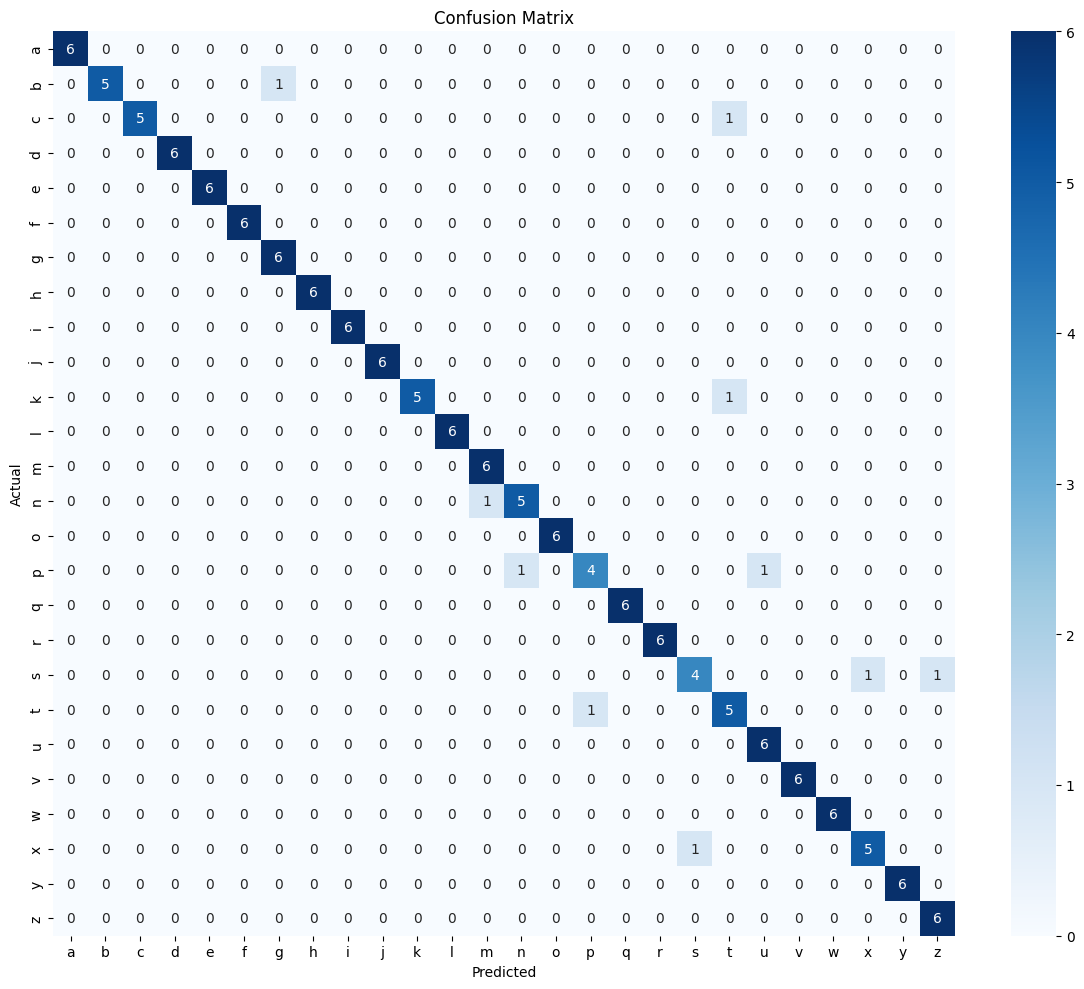

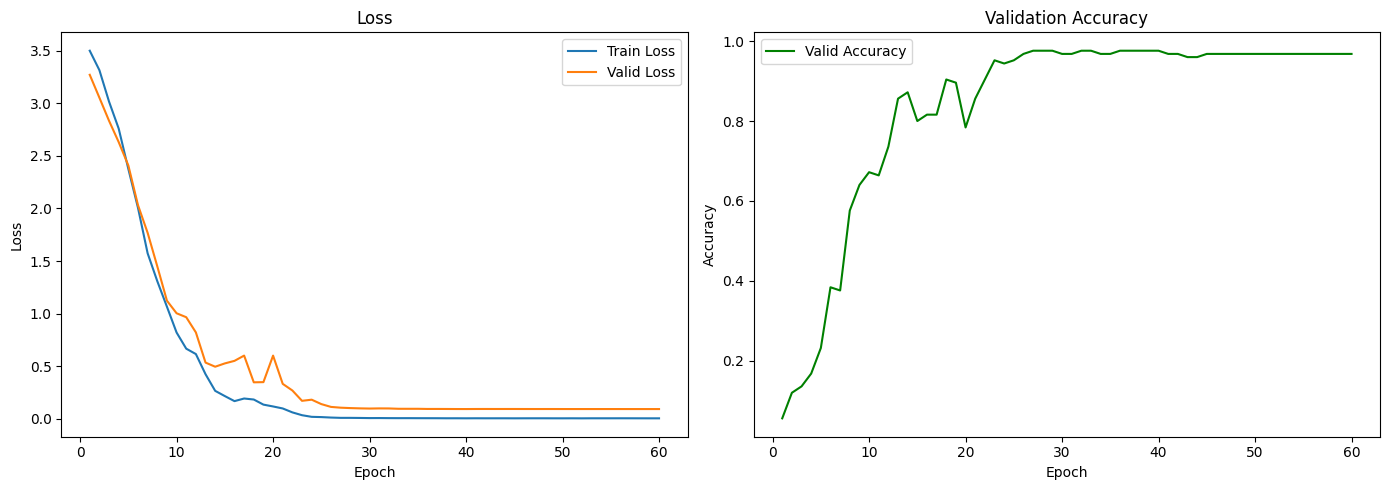


Evaluation for Region: bali
Accuracy : 0.9615
Precision: 0.9423
Recall   : 0.9615
F1 Score : 0.9487

Classification Report:
              precision    recall  f1-score   support

           a       0.50      1.00      0.67         3
           b       1.00      1.00      1.00         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      1.00      1.00         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      1.00      1.00         3
           n       1.00      1.00      1.00         3
           o       1.00      1.00      1.00         3
          

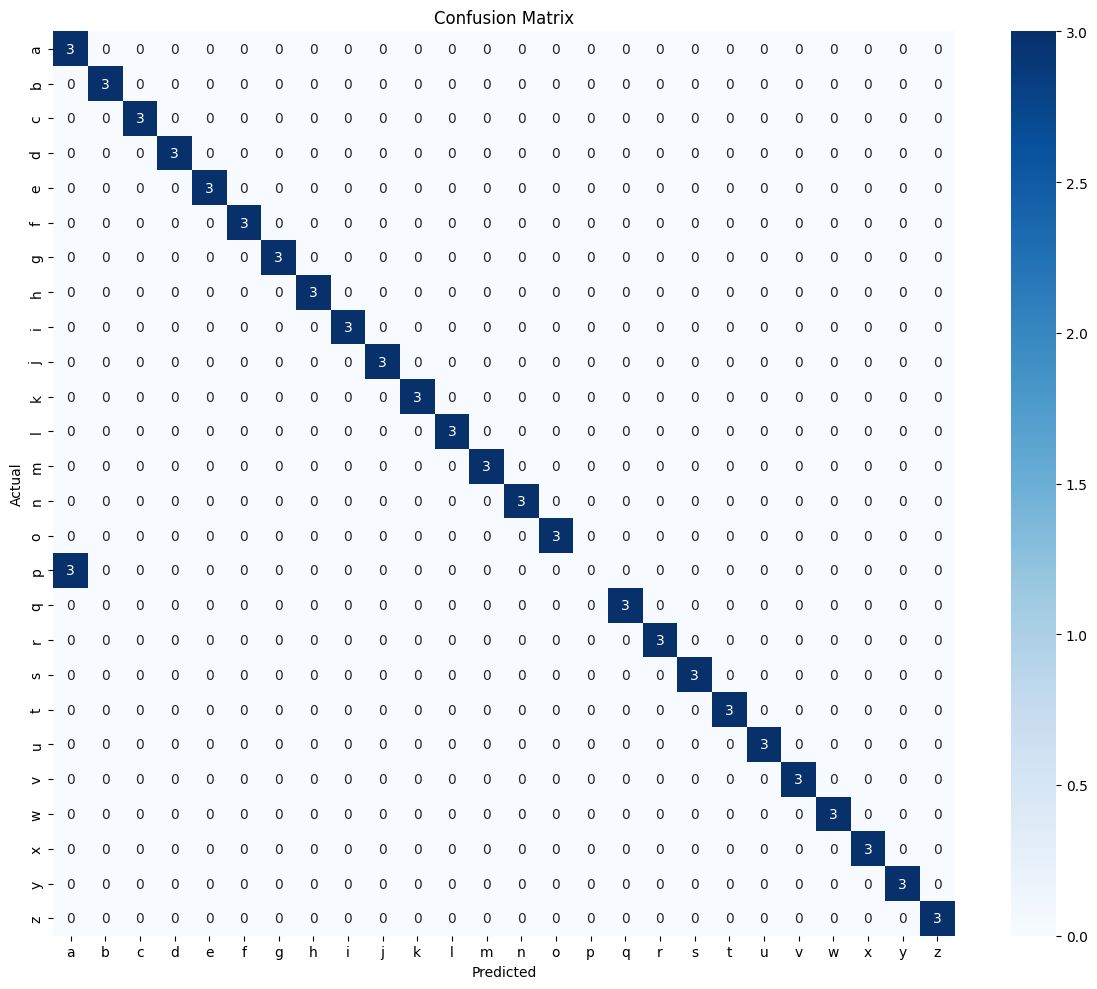

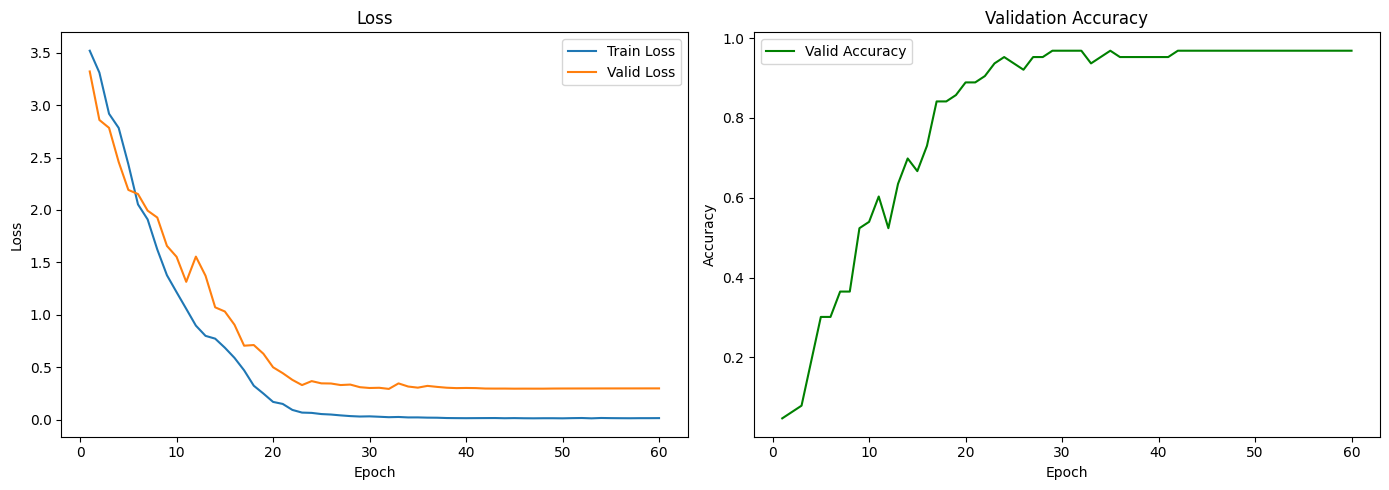


Evaluation for Region: madura
Accuracy : 0.8974
Precision: 0.9107
Recall   : 0.8974
F1 Score : 0.8912

Classification Report:
              precision    recall  f1-score   support

           a       0.43      1.00      0.60         3
           b       1.00      0.67      0.80         3
           c       1.00      1.00      1.00         3
           d       1.00      1.00      1.00         3
           e       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         3
           g       1.00      0.67      0.80         3
           h       1.00      1.00      1.00         3
           i       1.00      1.00      1.00         3
           j       1.00      1.00      1.00         3
           k       1.00      1.00      1.00         3
           l       1.00      1.00      1.00         3
           m       1.00      0.67      0.80         3
           n       0.75      1.00      0.86         3
           o       1.00      1.00      1.00         3
        

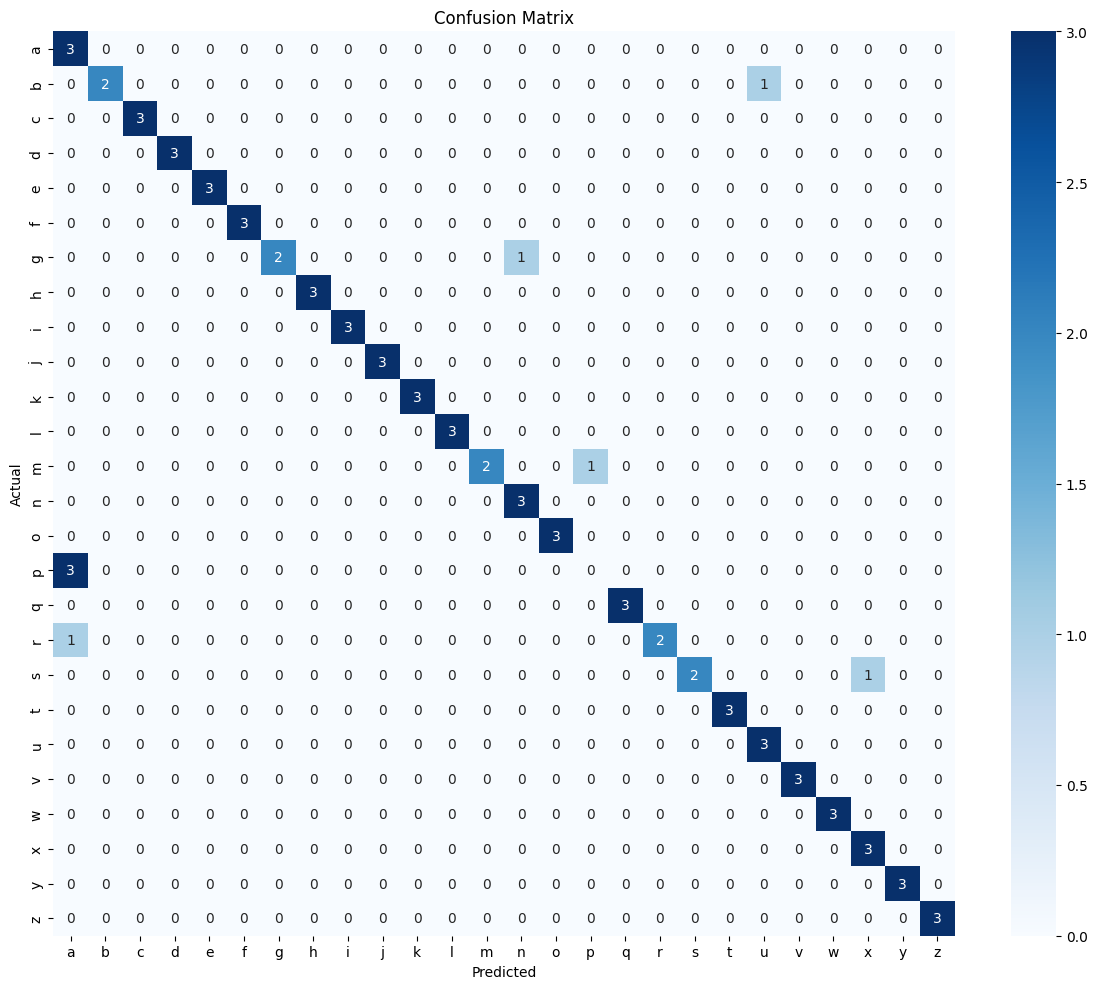

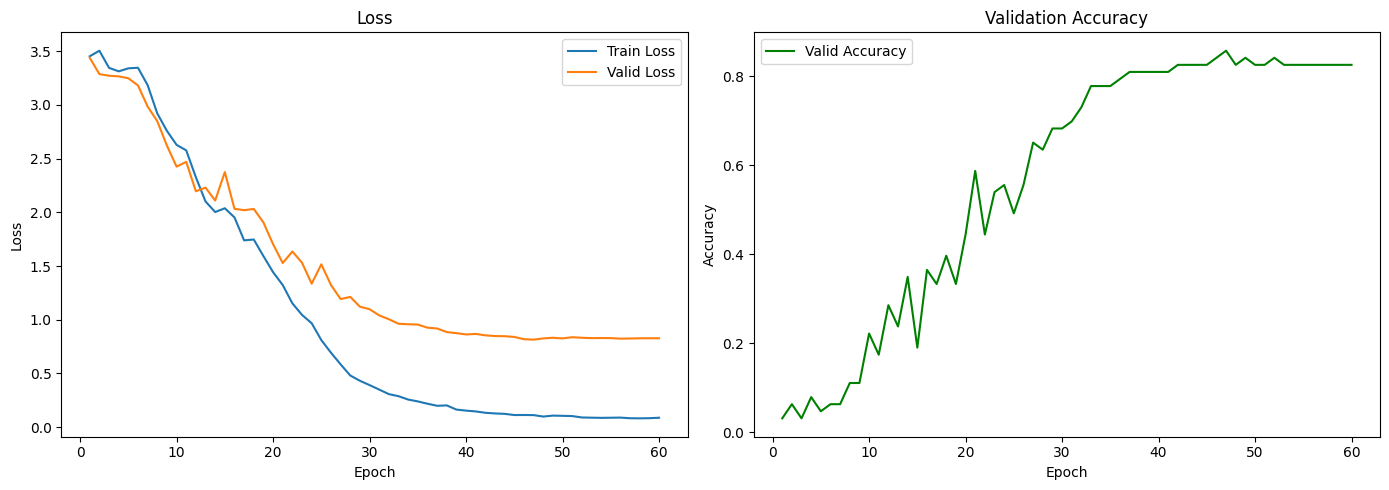


Evaluation for Region: papua
Accuracy : 0.9808
Precision: 0.9827
Recall   : 0.9808
F1 Score : 0.9806

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         4
           b       1.00      1.00      1.00         4
           c       0.80      1.00      0.89         4
           d       1.00      1.00      1.00         4
           e       1.00      1.00      1.00         4
           f       1.00      1.00      1.00         4
           g       1.00      0.75      0.86         4
           h       1.00      1.00      1.00         4
           i       1.00      1.00      1.00         4
           j       1.00      1.00      1.00         4
           k       0.75      0.75      0.75         4
           l       1.00      1.00      1.00         4
           m       1.00      1.00      1.00         4
           n       1.00      1.00      1.00         4
           o       1.00      1.00      1.00         4
         

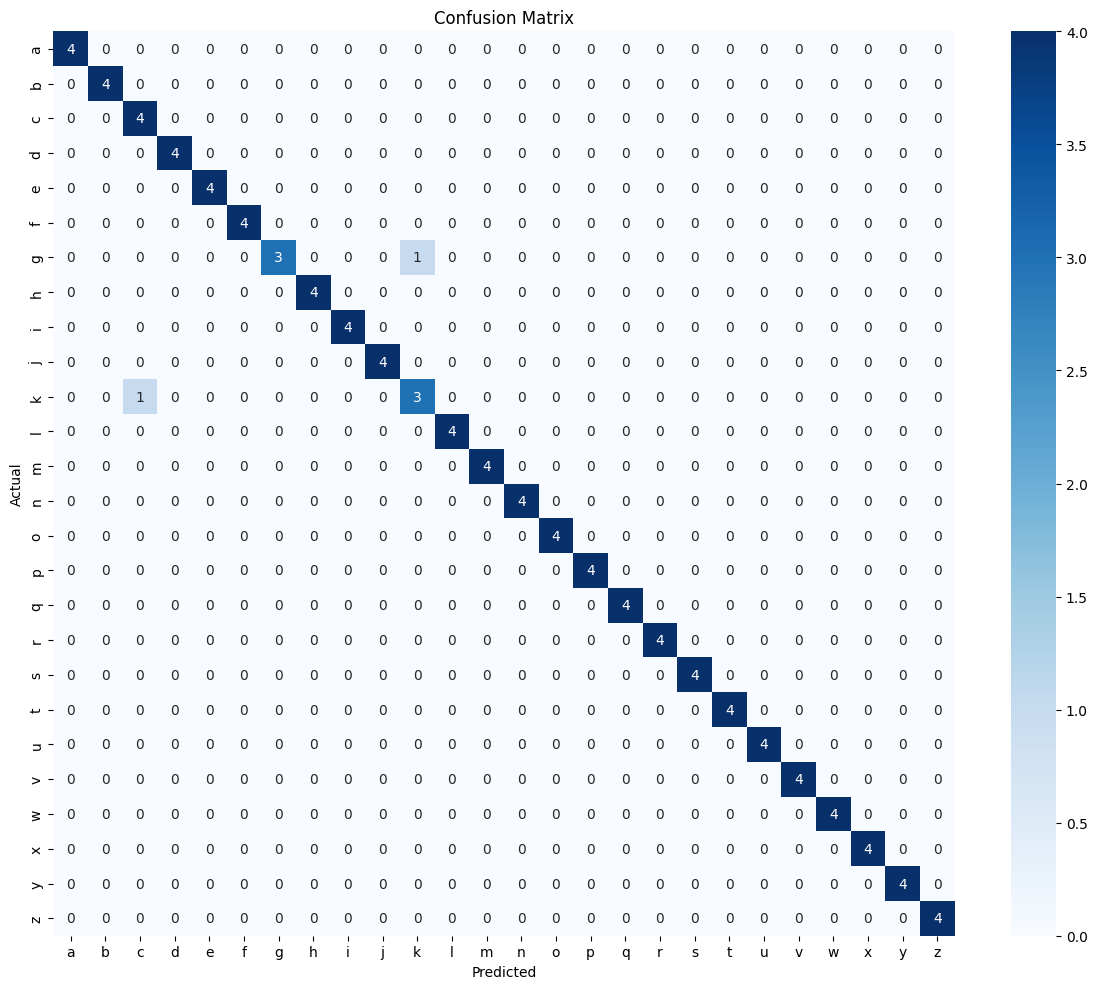

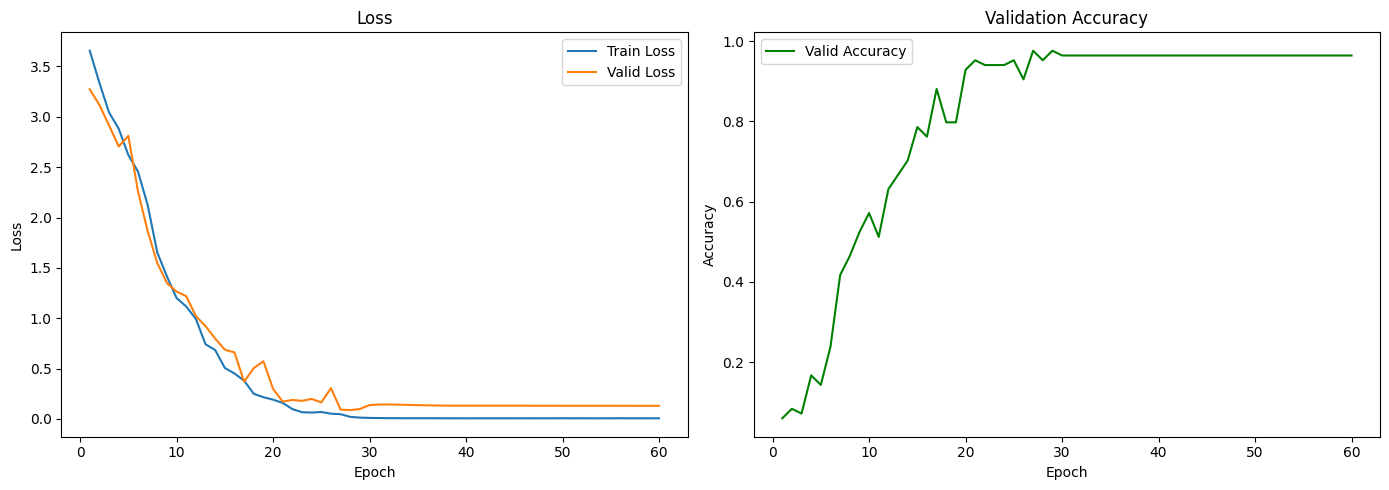

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs+1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs+1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs+1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def evaluate_all_regions(region_results, transformer_models_by_region):
    for region_name, region_data in region_results.items():
        print(f"\nEvaluation for Region: {region_name}")
        model = transformer_models_by_region[region_name]['model']
        label_encoder = transformer_models_by_region[region_name]['label_encoder']
        evaluate_model(model, region_data['X_test'], region_data['y_test'], label_encoder)
        plot_training_history(model)

if __name__ == '__main__':
    evaluate_all_regions(region_results, transformer_models_by_region)